In [1]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.cuda.amp import autocast, GradScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torchvision.utils as vutils
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

In [2]:
device

device(type='cuda')

In [3]:
config = {
    "dataset": {
        "train": {
            "table": "./data/train.csv",
            "data": "./data/bare_data/"
        },
        "val": {
            "table": "./data/val.csv",
            "data": "./data/bare_data/"
        }
    },
    "train": {
        "batch_size": 128,
        "grad_acum": 1,
        "dtype": "float32",
        'shuffle': True,
        'pin_memory': True,
    },
    "val": {
        "batch_size": 128,
        "grad_acum": 1,
        "dtype": "float32",
        'shuffle': False,
        'pin_memory': True,
    },
    "vae": {
        "freq": 16000,
        "lenght": 5,
    },
    "model": {
        "latent_size": 128,
        "epochs": 15,
        "learning_rate": 0.001,
        "freq_scale": 4,
        "time_scale": 4,
    },
    "utils": {
        "n_fft": 800, # TODO
    }
}

# VAE

In [4]:
class VAE_Audio(nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder_input = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.GELU(),
            nn.Conv2d(32, 16, 3, 1, 1), nn.BatchNorm2d(16), nn.GELU(),
        )
        self.encoder_squeeze = nn.Sequential(
            nn.Conv2d(16, 16, 3, 2, 1), nn.GELU(),
            nn.Conv2d(16, 16, 3, 2, 1), nn.GELU(),
        )
        self.encoder_mu     = nn.Conv2d(16, 32, 1)
        self.encoder_logvar = nn.Conv2d(16, 32, 1)
        self.decoder_unsqueeze = nn.Sequential(
                nn.ConvTranspose2d(32, 32, 3, 2, 1, output_padding=1), nn.GELU(),
                nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1), nn.GELU(),
        )
        self.decoder_output = nn.Sequential(
                 nn.ConvTranspose2d(16, 4, 3, 1, 1), nn.GELU(),
                 nn.BatchNorm2d(4),
                 nn.ConvTranspose2d(4, 1, 3, 1, 1), 
        )
    def encode(self, x):
        x = self.encoder_input(x)
        x = self.encoder_squeeze(x)
        mu = self.encoder_mu(x)
        logvar = self.encoder_logvar(x)
        return mu, logvar
    def sample(self, x):
        mu, logvar = self.encode(x)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
        return z, mu, logvar
    def decode(self, x):
        x = self.decoder_unsqueeze(x)
        x = self.decoder_output(x)
        return x
    def KLD_loss(self, mu, logvar, q=0.02):
        kld = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        kld = torch.clamp(kld, min=q)
        return kld.mean()
    def forward(self, x):
        z, mu, logvar = self.sample(x)
        return self.decode(z), z, mu, logvar     

In [5]:
from pathlib import Path

vae = VAE_Audio().to(device)
params = torch.load(str(Path.home() / "Downloads" / "VaeAudio_V4_noise.pt"), map_location=device, weights_only=True)
vae.load_state_dict(params)
vae.eval()

VAE_Audio(
  (encoder_input): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
  )
  (encoder_squeeze): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): GELU(approximate='none')
  )
  (encoder_mu): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (encoder_logvar): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (decoder_unsqueeze): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GELU(approximate=

# Моделька

In [6]:
class NoiseScheduler:
    def __init__(self, timestamps=100, epochs=100):
        self.steps = timestamps
        self.epochs = epochs
        self.betas = torch.linspace(0.02, 0.0004, timestamps)
        self.alpha = 1 - self.betas
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def __call__(self, step):
        return self.betas[step]
    def corrupt_image(self, image, idx):
        noise = torch.randn_like(image)
        b = image.shape[0]
        k = self.alpha_hat[idx].view(b, 1, 1, 1)
        return torch.sqrt(k)*image + torch.sqrt(1-k)*noise, noise

    def sample_timestamps(self, iters=10):
        indicies = torch.cat((torch.randint(0, self.steps-1, [iters-1]), torch.tensor(100)))
        return indicies

    def restore_image(self, image, pred, idx, sigma=0.0):
        noise = torch.randn_like(image)
        alpha = self.alpha[idx]
        alpha_hat = self.alpha_hat[idx]
        nalpha = 1-alpha
        nalpha_hat = 1-alpha_hat
        return (image - pred*nalpha/(torch.sqrt(nalpha_hat)))/torch.sqrt(alpha) + sigma*noise

    def get_idx(self, epoch, batch_size):
        return self.steps-torch.randint(0, self.steps, [batch_size]) - 1

In [7]:
class ResudialBlock(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.layers = nn.Sequential(*args)
    def forward(self, x):
        return x + self.layers(x)

class ConditionMixingLayer(nn.Module):
    def __init__(self, input_channels, conditioning_length, hidden_size = 8):
        super().__init__()
        self.hidden_size = hidden_size
        self.cond_proj = nn.Linear(conditioning_length, self.hidden_size)
        self.conv_proj = nn.Conv2d(input_channels, self.hidden_size, 3, 1, 1)
        self.lin_proj = nn.Linear(self.hidden_size, self.hidden_size)
        self.lin1_unproj = nn.Linear(self.hidden_size, self.hidden_size)
        self.lin2_unproj = nn.Linear(self.hidden_size, self.hidden_size)
        self.conv_unproj = nn.Conv2d(self.hidden_size, input_channels, 3, 1, 1)
        self.conv_act = nn.Tanh()
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.bn2 = nn.BatchNorm2d(input_channels)


        self.add_a = nn.Linear(self.hidden_size, self.hidden_size)
        self.add_b = nn.Linear(self.hidden_size, self.hidden_size)

    def forward(self, x, c=None, skip=False):
        if len(x.shape)==3:
            x = x.unsqueeze(0)
        b, ch, h, w = x.shape
        x = self.bn1(x)
        xn = self.conv_proj(x) # [B, N, H, W]
        xn = self.conv_act(xn)
        xn = xn.view(b, h*w, self.hidden_size) # [B, H*W, N]
        xn = self.lin_proj(xn) # [B, H*W, N]
        xn = self.conv_act(xn) # [B, H*W, N]
        if not skip:
            cn = self.cond_proj(c) # [B, N]
            cn = self.conv_act(cn) # [B, N]
            cn = cn.view(b, 1, self.hidden_size)
            xn = self.add_a(xn) # [B, 1, N]
            cn = self.add_b(cn) # [B, H*W, N]
            xn = xn + cn # [B, H*W, N]

        xn = self.lin1_unproj(xn) # [B, H*W, N]
        xn = self.conv_act(xn) # [B, H*W, N]
        xn = self.lin2_unproj(xn) # [B, H*W, N]
        xn = self.conv_act(xn) # [B, H*W, N]

        xn = xn.view(b, self.hidden_size, h, w) # [B, N, H, W]
        xn = self.conv_unproj(xn)
        xn = self.conv_act(xn) # [B, I, H, W]
        xn = self.bn2(xn)

        x = xn + x

        return x



class MNIST_diffusion(nn.Module):
    def __init__(self, input_channels=1, conditioning_length=1, timestamp_length=1, hidden_dims=32, mixin_dims=32):
        super().__init__()
        self.input_scaler = nn.Sequential(
                nn.Conv2d(in_channels=input_channels, out_channels=hidden_dims, kernel_size=1), nn.Tanh()
            )
        self.output_scaler = nn.Sequential(
                nn.Conv2d(in_channels=hidden_dims, out_channels=hidden_dims, kernel_size=1), nn.Tanh(),
                nn.Conv2d(in_channels=hidden_dims, out_channels=input_channels, kernel_size=1)
            )
        self.precode = nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            )
        self.mixing_layer = ConditionMixingLayer(hidden_dims, conditioning_length+timestamp_length, mixin_dims)
        self.encoder = nn.Sequential(
            ResudialBlock(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            ),
            nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims*4, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
                nn.PixelShuffle(2), #C/4
                nn.Conv2d(hidden_dims, hidden_dims, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
                nn.PixelUnshuffle(2), #C*4
                nn.Conv2d(hidden_dims*4, hidden_dims, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
            ),
            ResudialBlock(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
            ),
        )
        self.downscaler = nn.Sequential(
            nn.Conv2d(hidden_dims, hidden_dims, 3, 2, 1), nn.BatchNorm2d(hidden_dims), nn.Tanh(),
            nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
        )

        self.upscaler = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims, hidden_dims, 3, 2, 1, output_padding=1), nn.BatchNorm2d(hidden_dims), nn.Tanh(),
            nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
        )
        self.decoder = nn.Sequential(
            ResudialBlock(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            ),
            nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims*4, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
                nn.PixelShuffle(2), #C/4
                nn.Conv2d(hidden_dims, hidden_dims, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
                nn.PixelUnshuffle(2), #C*4
                nn.Conv2d(hidden_dims*4, hidden_dims, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
            ),
            ResudialBlock(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            ),
        )
        self.padder = nn.ZeroPad2d(1)
    def encode(self, x, mix = False, c = None):
        x = self.input_scaler(x)
        x = self.precode(x)
        if mix and not c is None:
            x = self.mixing_layer(x, c, False)
        else:
            x = self.mixing_layer(x, c, True)
        x = self.encoder(x)
        return x
    def rescale(self, x, n=0):
        if n<=0:
            return x
        b, c, ho, wo = x.shape
        if not (ho%2==0 and wo%2==0):
            y = self.padder(x)
        else:
            y = x
        y = self.downscaler(y)
        b, c, h, w = y.shape
        z = self.rescale(y, n-1)
        z = nn.functional.interpolate(z, [h, w])
        y = y + z
        y = self.upscaler(y)
        y = nn.functional.interpolate(y, [ho, wo])
        x = y + x
        return x
    def decode(self, x):
        x = self.decoder(x)
        x = self.output_scaler(x)
        return x
    def forward(self, x, mix=False, c = None, n=1):
        x = self.encode(x, mix, c)
        x = self.rescale(x, n)
        x = self.decode(x)
        return x


# Тренер

In [8]:
from tqdm.auto import tqdm
from torch import amp
import math
import os
class AvegereMeter:
    def __init__(self,):
        self.arr = []
    def __call__(self, item, n=1):
        if n<=1:
            self.arr.extend([item])
        else:
            self.arr.extend([item]*n)
    def __str__(self,) -> str:
        return str(np.mean(np.array(self.arr)))
    def zero(self,):
        self.arr=[]

class Diffusion_Trainer:
    def __init__(self, model, train_dataloader, val_dataloader, vae, epochs=50, ):
        self.model = model
        self.vae = vae
        self.device = next(model.parameters()).device
        self.tdl = train_dataloader
        self.vdl = val_dataloader
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=5e-4, weight_decay=1e-2) 
        self.l2_loss = nn.MSELoss(reduction='none')
        self.loss_meter = AvegereMeter()
        self.epochs = epochs
        self.losses = []
        self.noise_sched = NoiseScheduler(100, epochs)
        self.noise_sched.alpha = self.noise_sched.alpha.to(self.device)
        self.noise_sched.alpha_hat = self.noise_sched.alpha_hat.to(self.device)

    def draw_diffusion(self, S=5, epoch=0):
        fig, axes = plt.subplots(11, S+1, figsize=(S+1, 11))
        #fig.set_figure(plt.figure(figsize=(10,S+1)))
        noise = torch.randn([1, 32, 7, 7], device=self.device)
        transformed_weight = [noise.clone() for _ in range(11)]
        for i in range(0, 11):
            for j in range(S+1):

                if j>0:
                    #noise[0][0].numpy()+
                    idx = int((j/S)*99)
                    k = self.noise_sched(idx).item()
                    pred = self.model(transformed_weight[i], i<10, torch.tensor([*[0]*i,1,*[0]*(9-i), idx], dtype=torch.float32, device=self.device))
                    transformed_weight[i] = self.noise_sched.restore_image(transformed_weight[i], pred, idx, 1e-5)

                decoded = self.vae.decode(transformed_weight[i])  
                img = decoded.squeeze(0).squeeze(0).cpu().detach().numpy()
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                if i==0:
                    axes[i, j].set_title(f'{j/S}')
        os.makedirs('./train/dl1/', exist_ok=True)
        plt.savefig(f'./train/dl1/diff{S}_{epoch}.png')
        plt.close(fig)

    def train_loop(self, KLDk=0.5, epoch=0):
        self.model.train()
        self.loss_meter.zero()
        pbar = tqdm(self.tdl, desc = 'train')
        cnt = 0
        self.vae.train()
        for audio, cond in pbar:
            audio = audio.to(self.device).float()
            b, c, h, w = audio.shape
            z = self.vae.sample(audio)[0]
            #audio = z
            with torch.autocast('cuda', dtype=torch.bfloat16):
                idx = self.noise_sched.get_idx(epoch, b).to(self.device)
                model_input, noise = self.noise_sched.corrupt_image(z, idx)
                model_input = model_input.to(self.device)
                noise = noise.to(self.device)
        
                cond_onehot = nn.functional.one_hot(cond, num_classes=10).float().to(self.device)
                condition = torch.cat([cond_onehot, idx.view(-1,1)], dim=1)

                if np.random.randint(10) <= 1:
                    output = self.model(model_input)
                else:
                    output = self.model(model_input, True, condition, np.random.randint(0,2))
        
                noise_loss = self.l2_loss(output, noise)
                loss = noise_loss.mean()
        
            self.optimizer.zero_grad()
            self.losses.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            pbar.desc = f'train, loss = {torch.mean(loss.detach().cpu().flatten()):.3f}'
            self.loss_meter(torch.mean(loss.detach().cpu().flatten()), audio.shape[0])

        print("Loss = "+self.loss_meter.__str__())

    def save_loss(self, filepath):
        with open(filepath, "w") as f:
            f.write(str(self.loss_meter))

    def save_image(self, audio, output, iter = 0):
        input_tensor = audio.cpu().detach().squeeze(0)   # shape [1, H, W]
        output_tensor = output.cpu().detach().squeeze(0)  # shape [1, H, W]

        # Преобразование в PIL-изображение
        transform = transforms.ToPILImage('RGB')
        rgb_input = torch.cat([input_tensor,  input_tensor,  input_tensor ], dim=0)
        rgb_output = torch.cat([output_tensor, output_tensor, output_tensor], dim=0)
        input_image = transform(rgb_input)
        output_image = transform(rgb_output)

        os.makedirs('./train', exist_ok=True)
        # Сохранение изображений
        input_image.save(f'./train/input_{iter}.png')
        output_image.save(f'./train/output_{iter}.png')

    def val_loop(self, iteration=0):
        self.model.eval()
        _, cond = next(iter(self.vdl))
        cond_label = cond[:1].to(self.device)
        cond_onehot = torch.nn.functional.one_hot(cond_label, 10).float().to(self.device)
    
        with torch.no_grad():
            dummy = self.vae.sample(torch.zeros(1,1,28,28, device=self.device))[0]
        _, C_lat, H_lat, W_lat = dummy.shape
        v = torch.randn(1, C_lat, H_lat, W_lat, device=self.device)
        T = self.noise_sched.steps
        n_snap = 10
        snap_ts = set(np.linspace(T-1, 0, n_snap, dtype=int).tolist())
        snapshots = []
        # 4) Обратный диффузионный проход
        with torch.no_grad():
            for t in range(T-1, -1, -1):
                # 4.1) формируем conditioning: [one-hot класс | текущее t]
                t_tensor = torch.tensor([[float(t)]], device=self.device)    # [1,1]
                condition = torch.cat([cond_onehot, t_tensor], dim=1)        # [1,11]
    
                # 4.2) предсказываем шум ε_t
                eps_pred = self.model(v, mix=True, c=condition, n=1)
    
                # 4.3) шаг назад: получаем v_{t-1}
                v = self.noise_sched.restore_image(v, eps_pred, t, sigma=0.0)
                if t in snap_ts:
                    a_hat_t = self.noise_sched.alpha_hat[t].to(self.device)
                    x0_pred = (v - torch.sqrt(1 - a_hat_t) * eps_pred) / torch.sqrt(a_hat_t)
                    decoded = self.vae.decode(x0_pred.to(torch.float32))
                    img = decoded.squeeze(0).squeeze(0).cpu().numpy()
                    snapshots.append((t, img))
    
        cols = len(snapshots)
        fig, axes = plt.subplots(1, cols, figsize=(cols*2, 2), dpi=150)
        for i, (t_val, img) in enumerate(snapshots):
            axes[i].imshow(img, cmap='grey')
            axes[i].set_title(f"t={t_val}", fontsize=8)
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()
        plt.close(fig)

In [9]:
unet = MNIST_diffusion(
    input_channels=32,       
    conditioning_length=10,
    timestamp_length=1,
    hidden_dims=128,      
    mixin_dims=128           
).to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(train_ds, batch_size=config['train']['batch_size'], shuffle=config['train']['shuffle'], num_workers=0, pin_memory=config['train']['pin_memory'])
val_dataloader = DataLoader(val_dataset, batch_size=config['val']['batch_size'], shuffle=config['val']['shuffle'], num_workers=0, pin_memory=config['val']['pin_memory'])

In [10]:
dummy = torch.zeros(1, 1, 28, 28, device=device)
with torch.no_grad():
    z = vae.sample(dummy)[0]
print('shape of z from VAE:', z.shape)

shape of z from VAE: torch.Size([1, 32, 7, 7])



 Epoch: 1/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.5705589


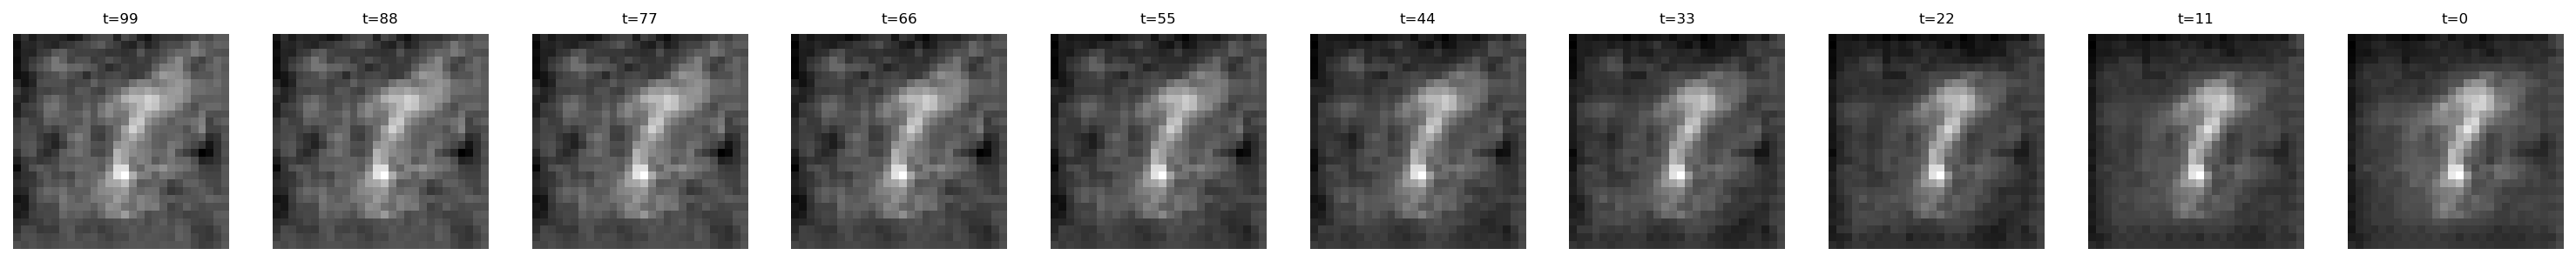


 Epoch: 2/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.47309005


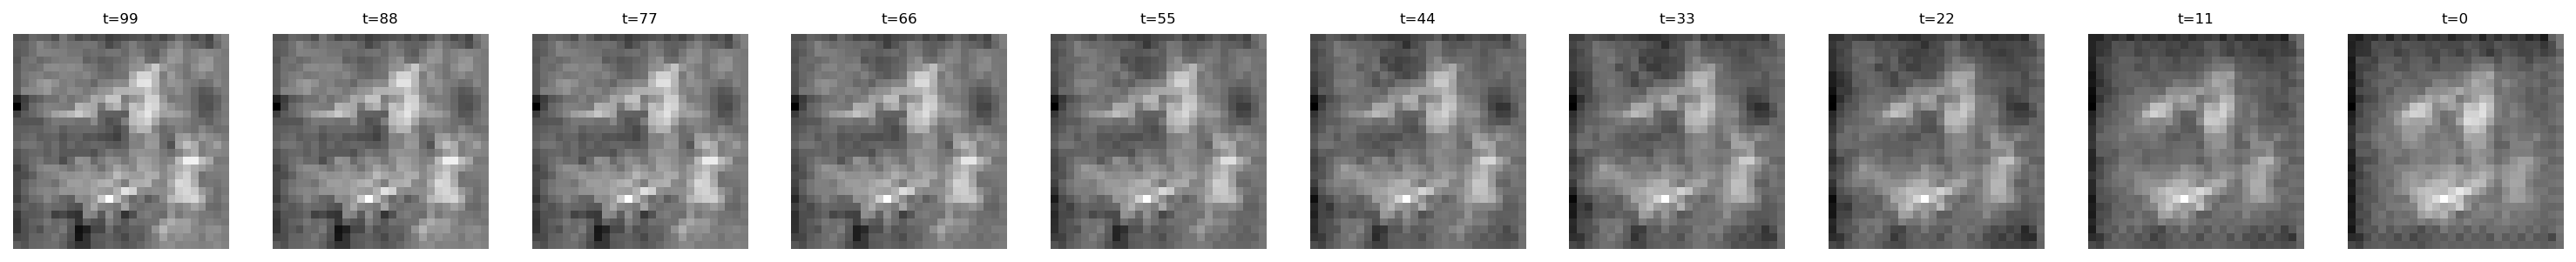


 Epoch: 3/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.45846507


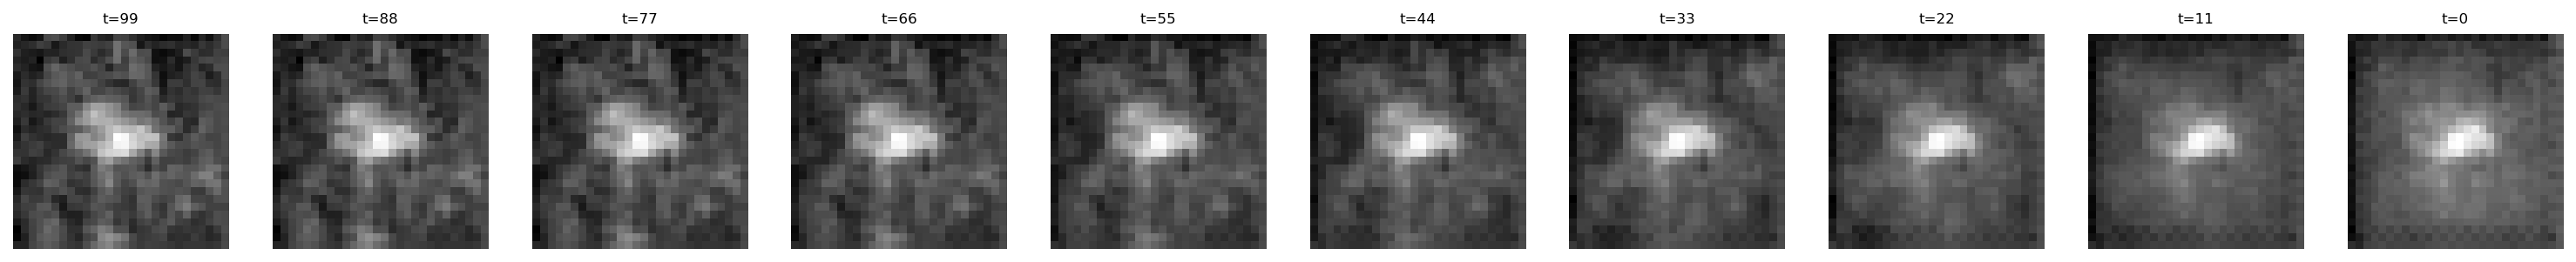


 Epoch: 4/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.4502549


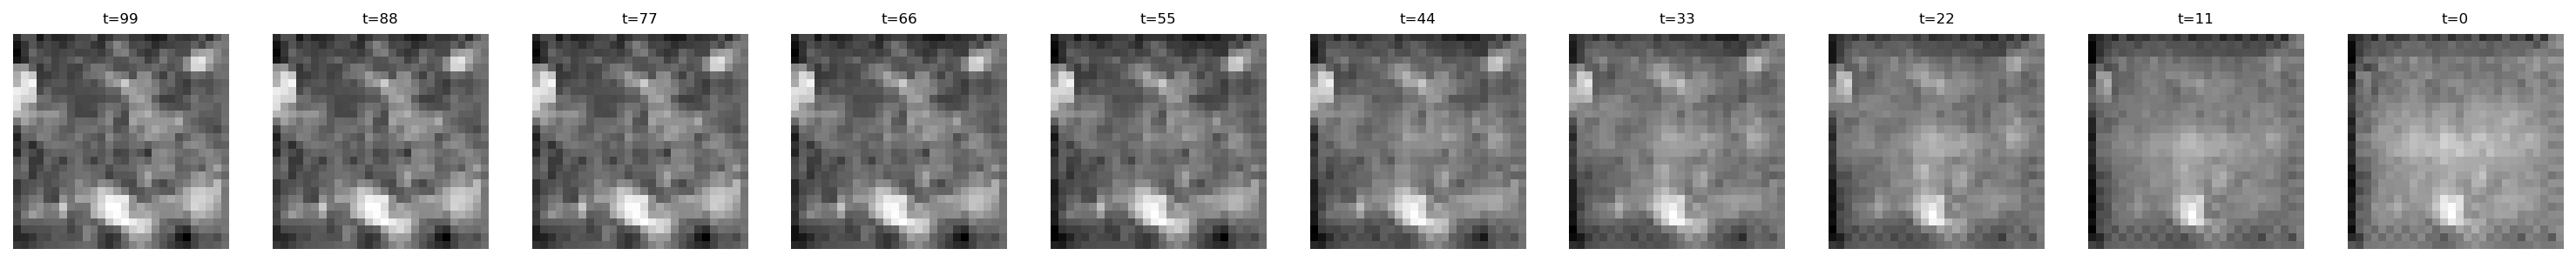


 Epoch: 5/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.44518054


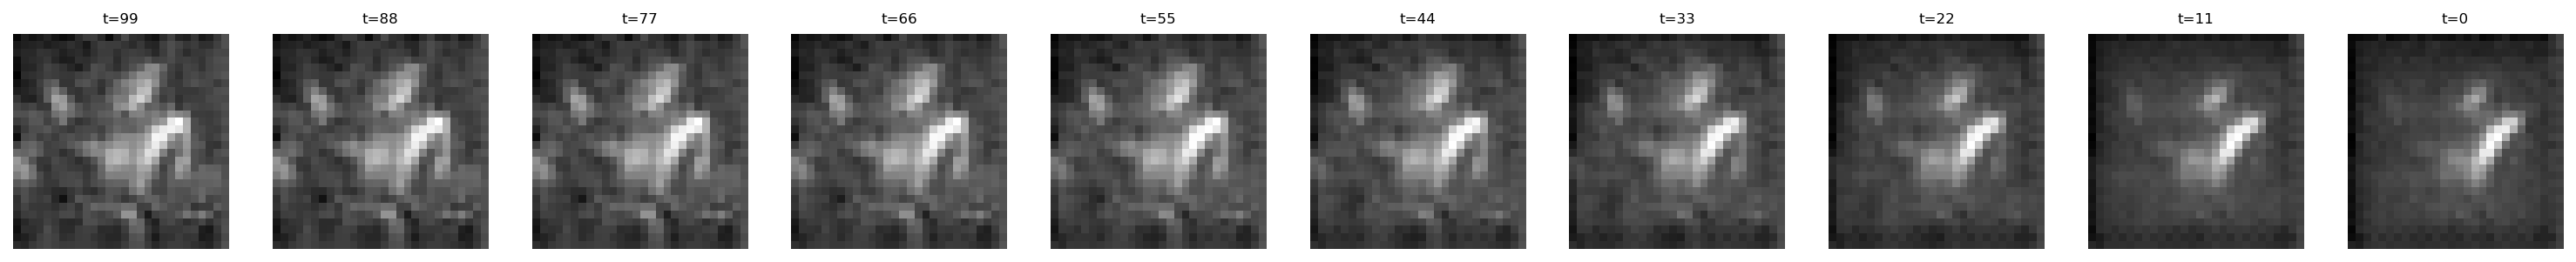


 Epoch: 6/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.44045585


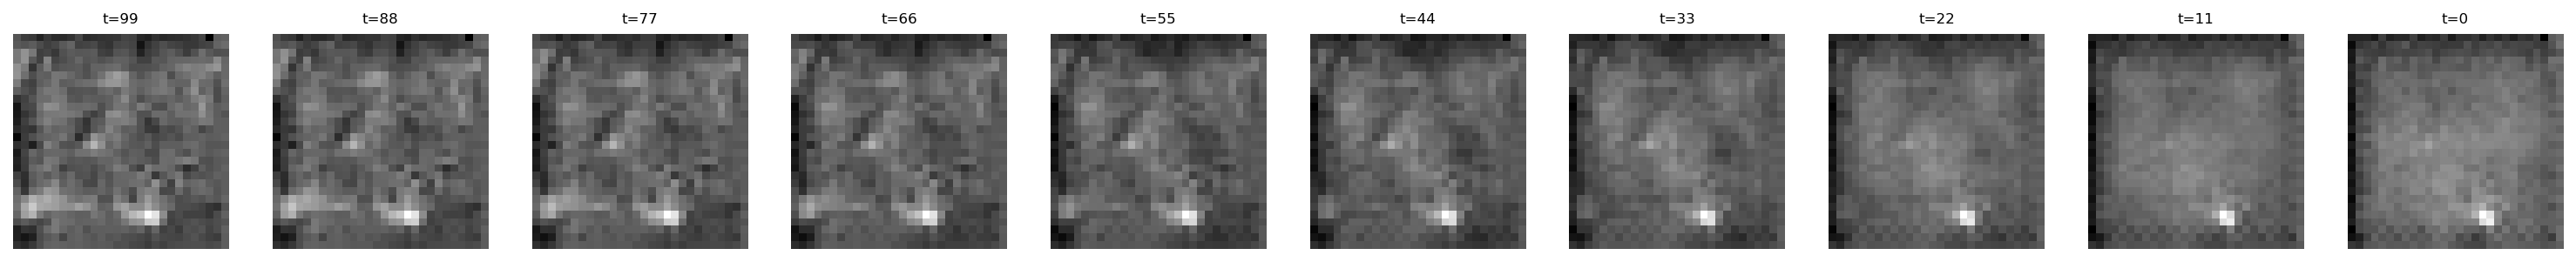


 Epoch: 7/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.43668973


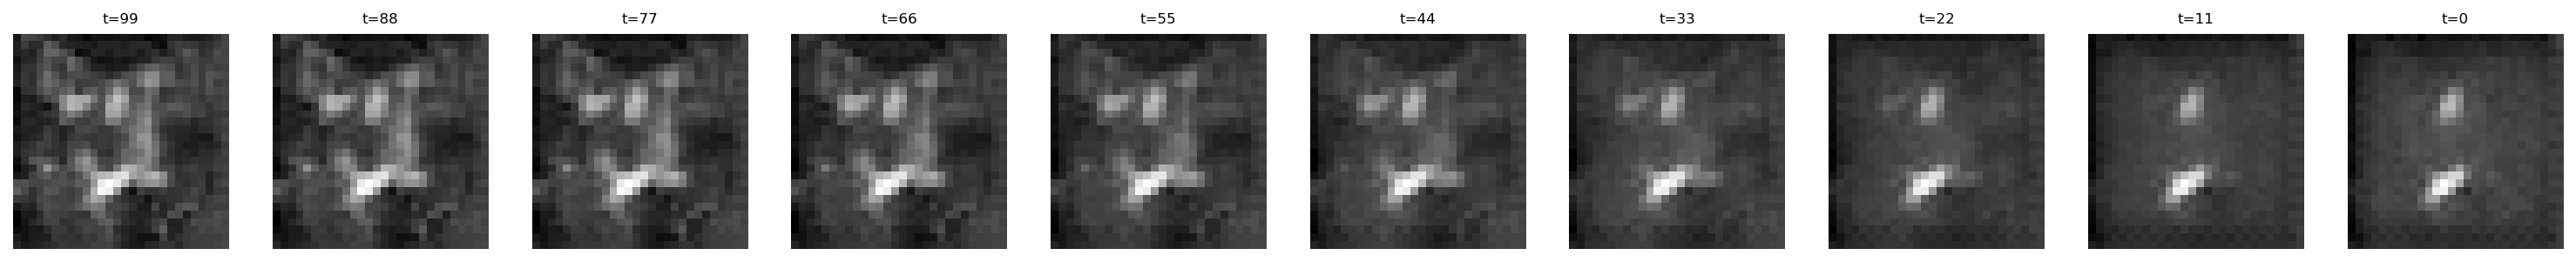


 Epoch: 8/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.4348543


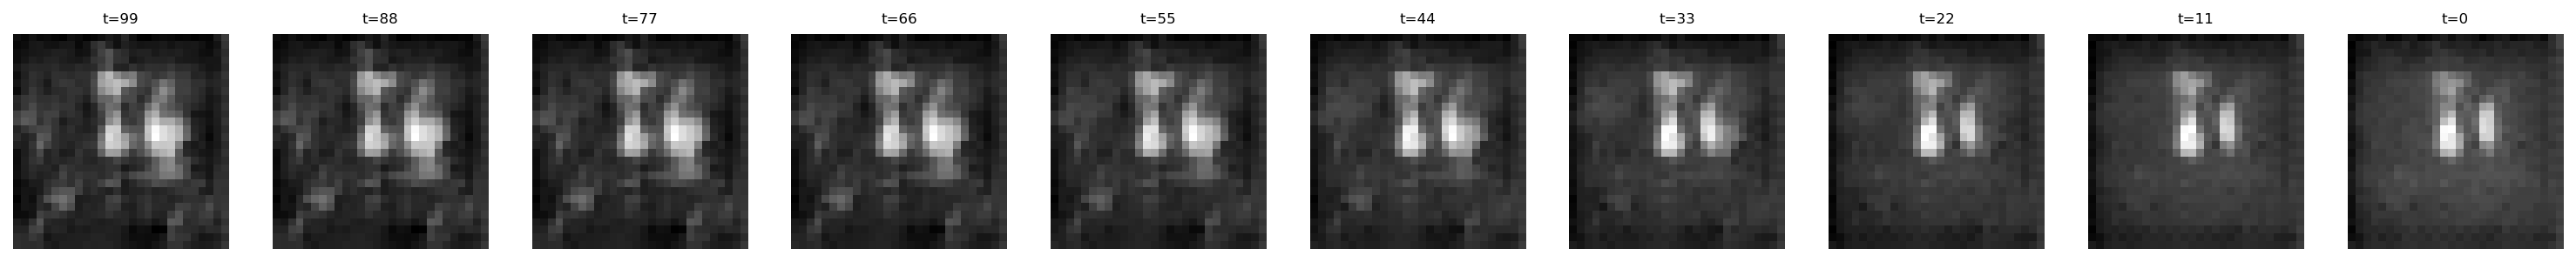


 Epoch: 9/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.43138987


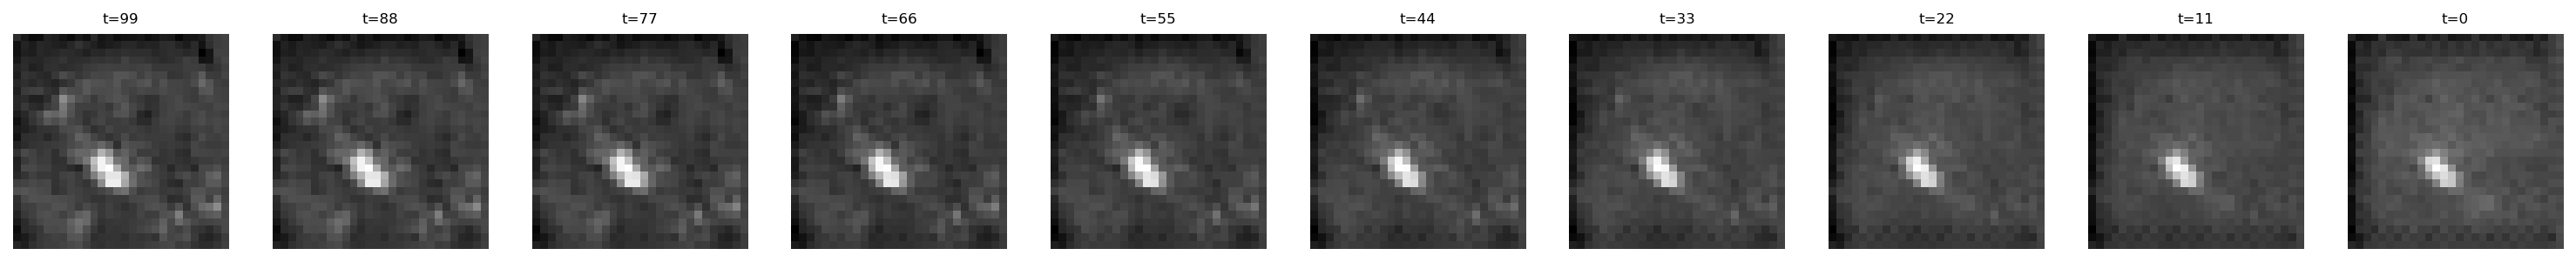


 Epoch: 10/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.4283691


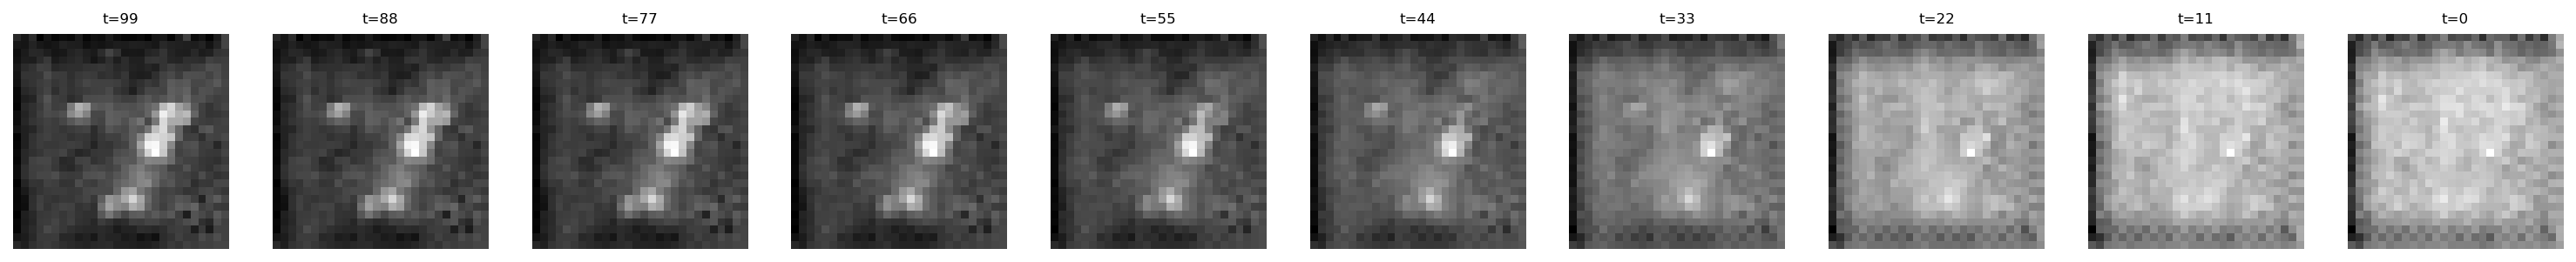


 Epoch: 11/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.42811573


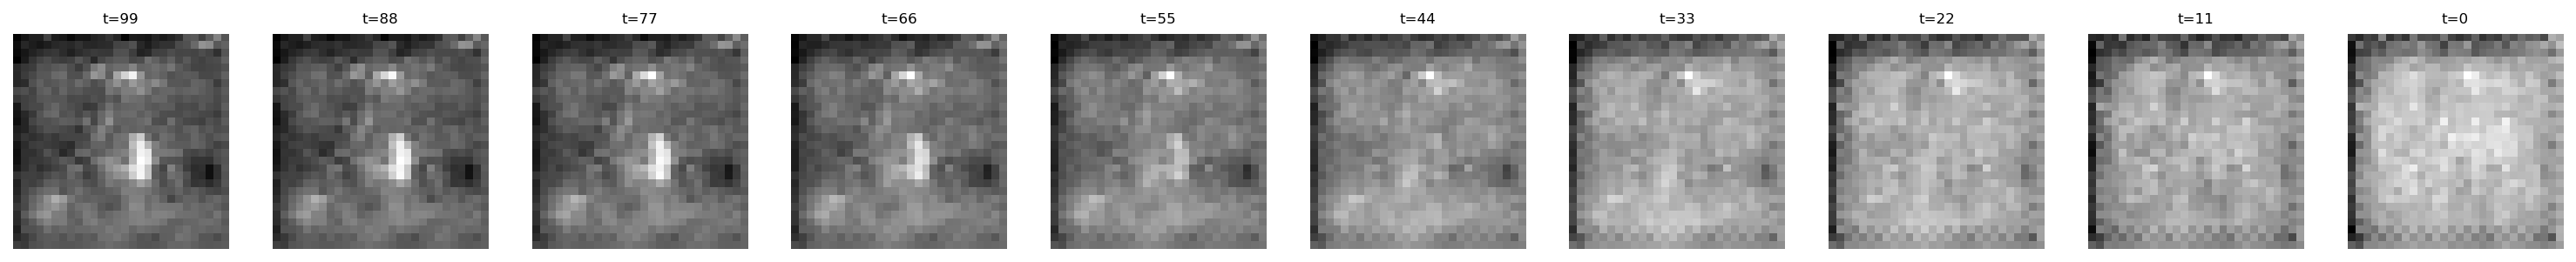


 Epoch: 12/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.42589727


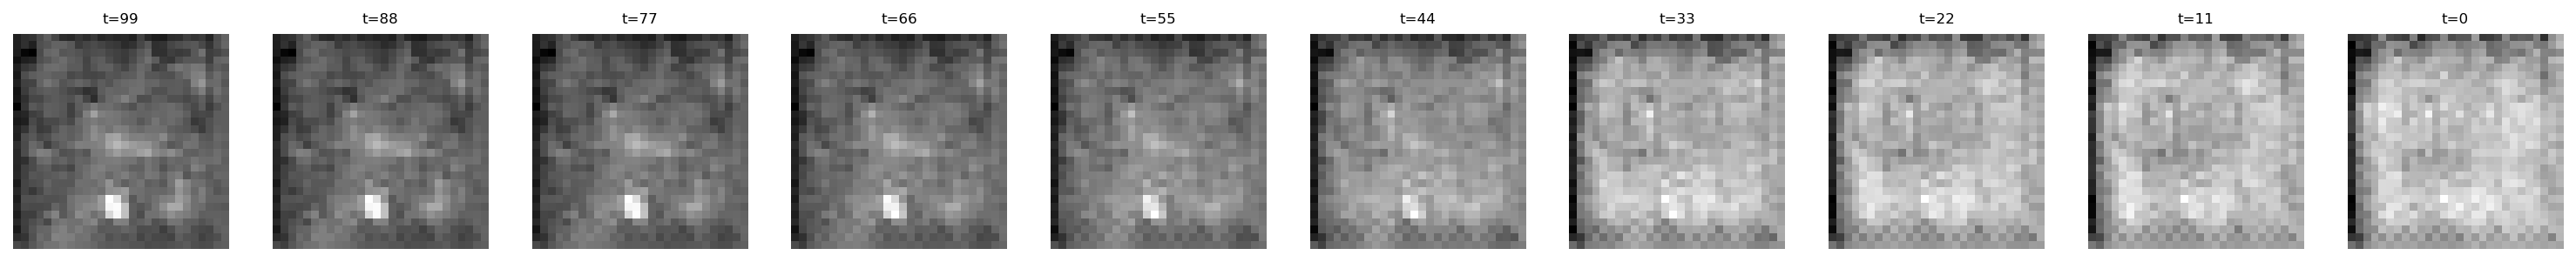


 Epoch: 13/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.42318234


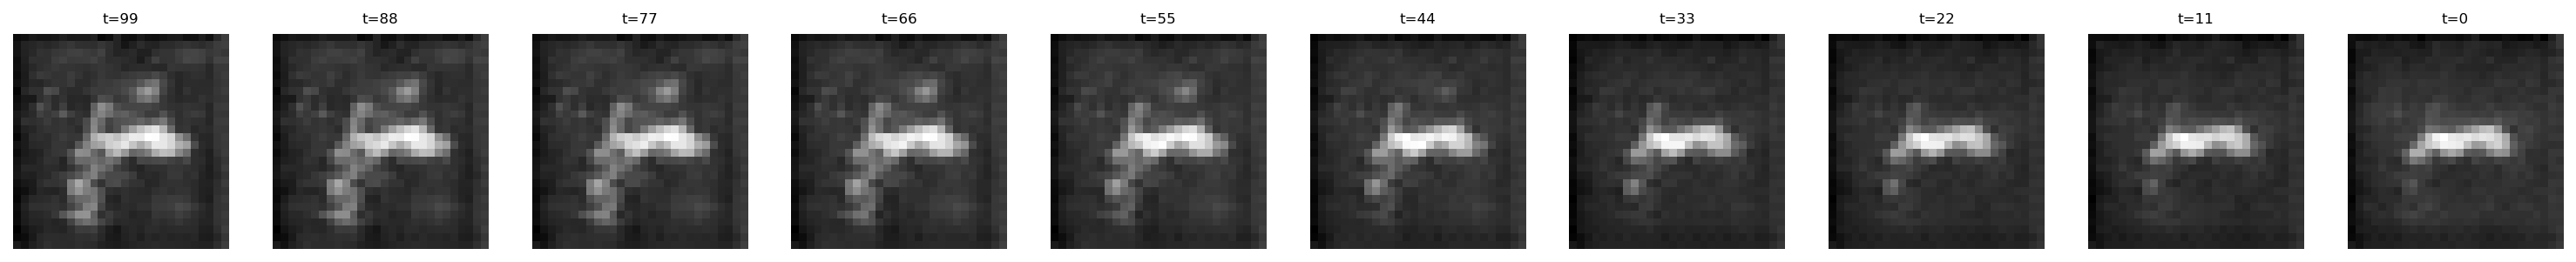


 Epoch: 14/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.4223117


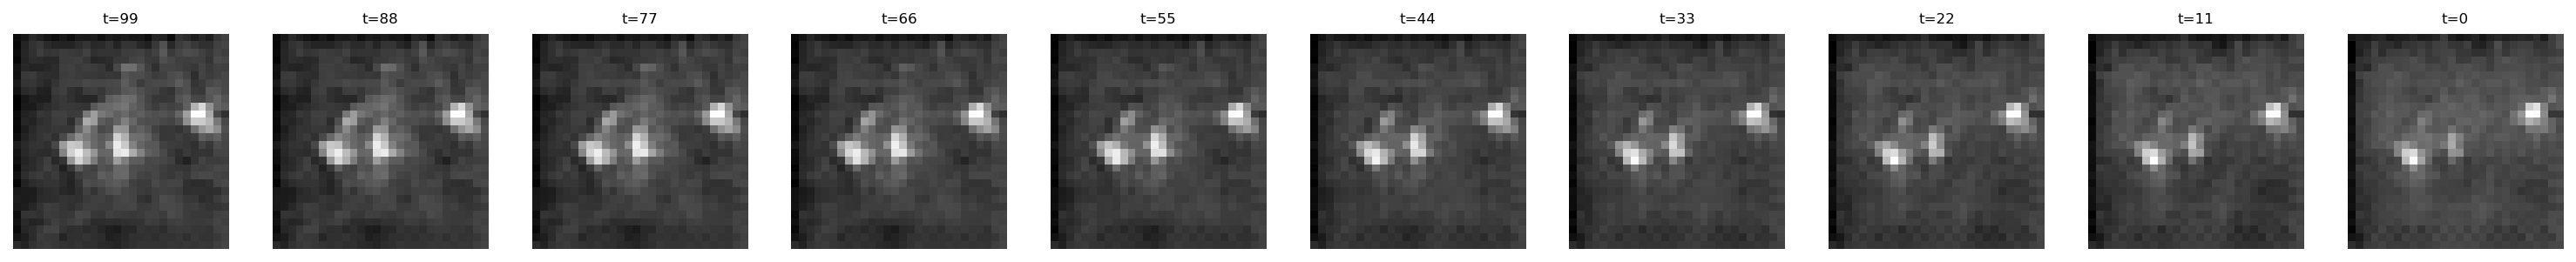


 Epoch: 15/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.420029


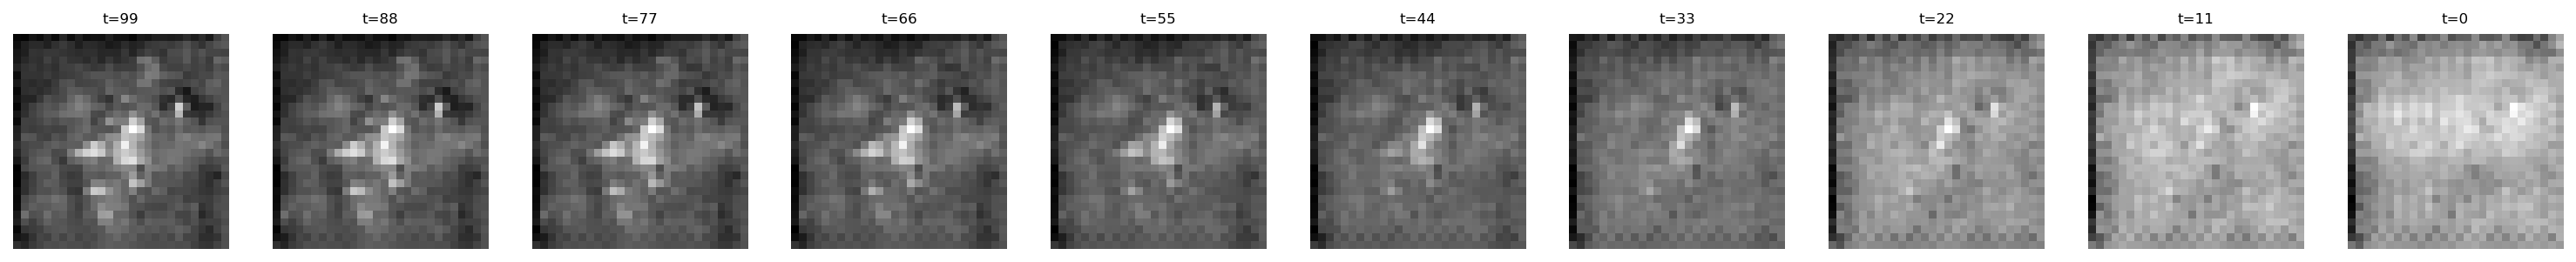


 Epoch: 16/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.42037237


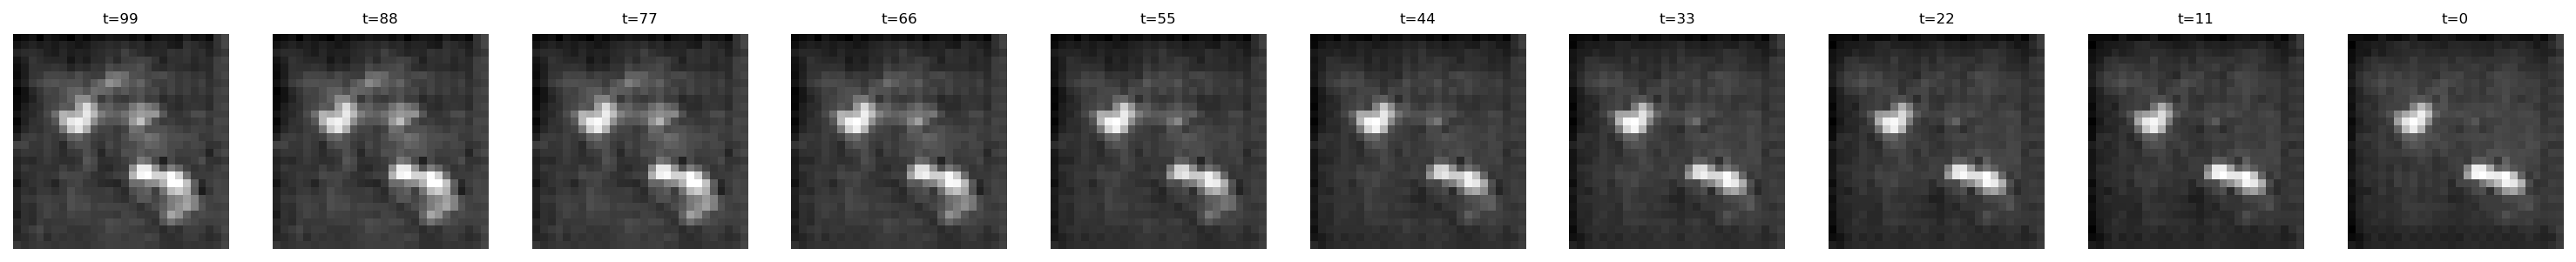


 Epoch: 17/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.42113554


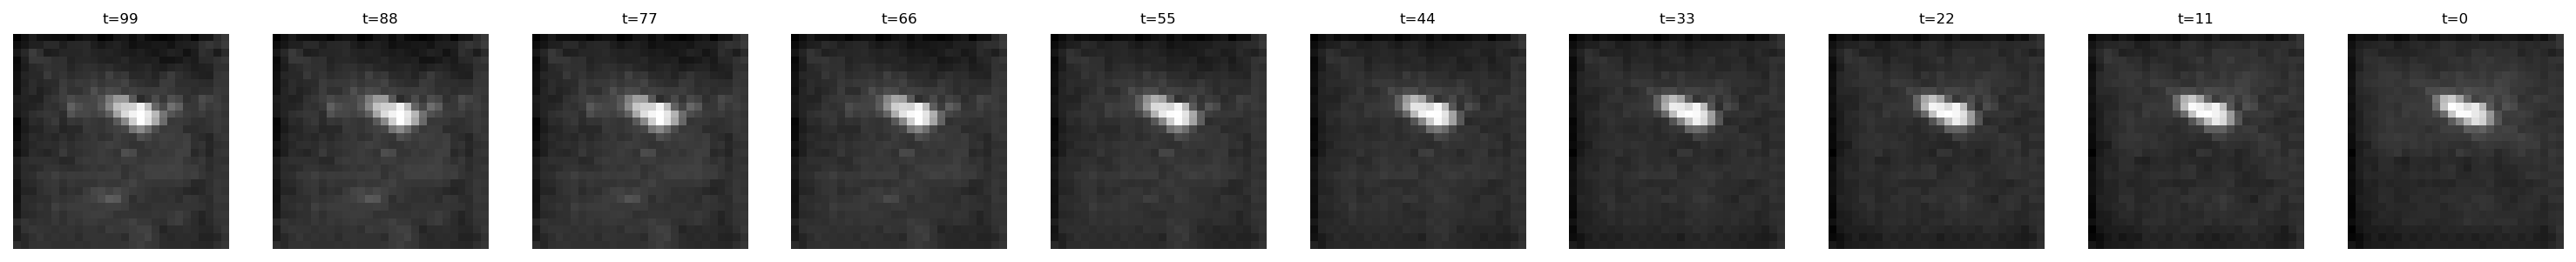


 Epoch: 18/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41939428


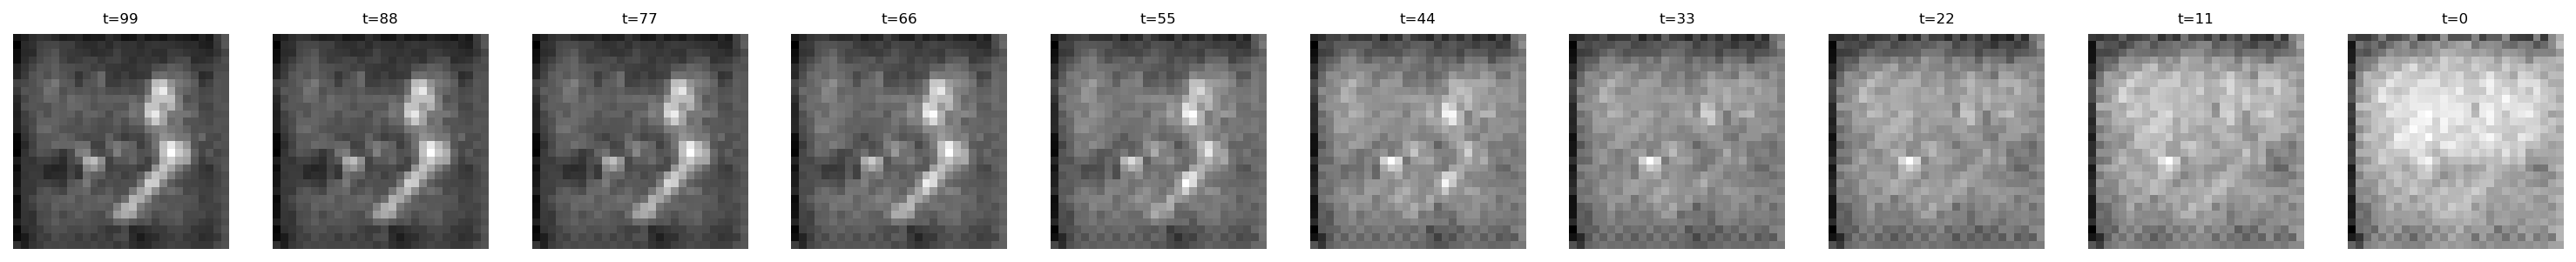


 Epoch: 19/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.4186411


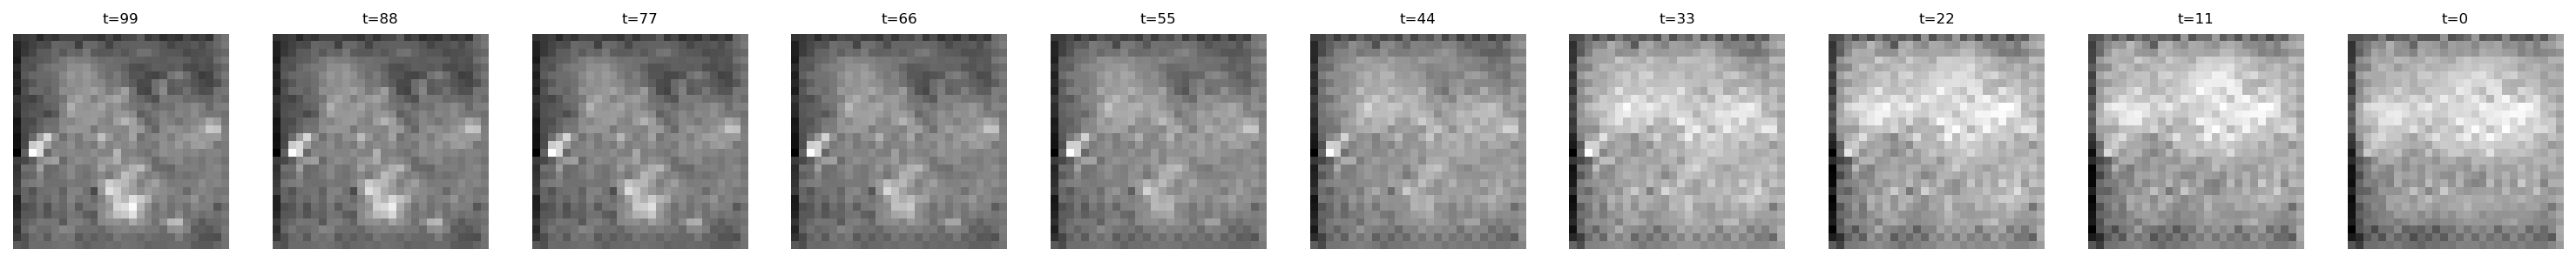


 Epoch: 20/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41887254


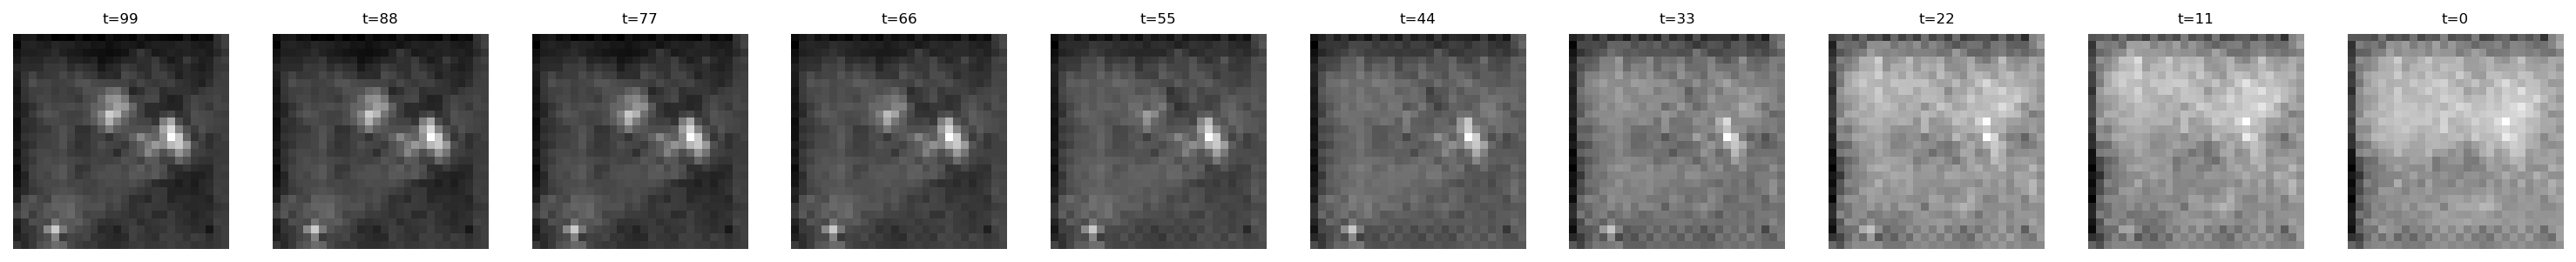


 Epoch: 21/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41771415


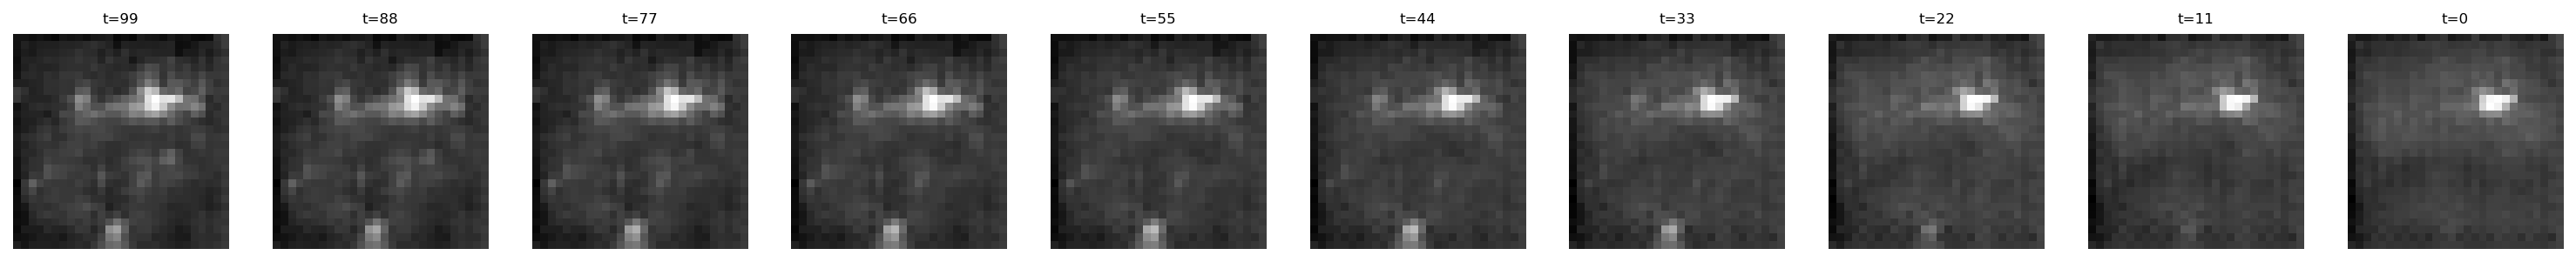


 Epoch: 22/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41741073


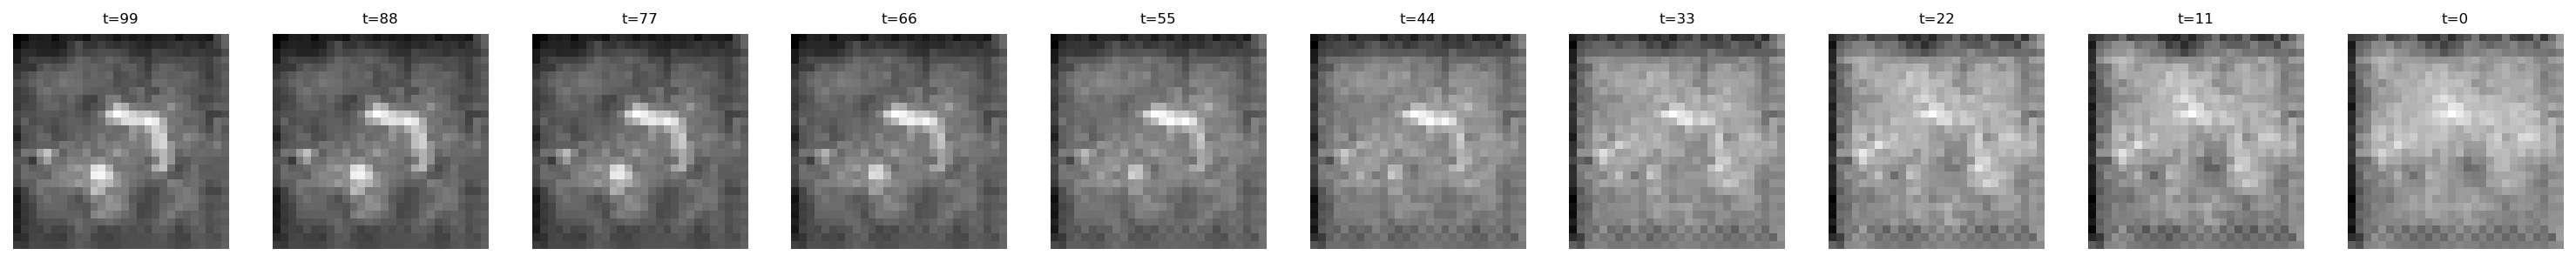


 Epoch: 23/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41681373


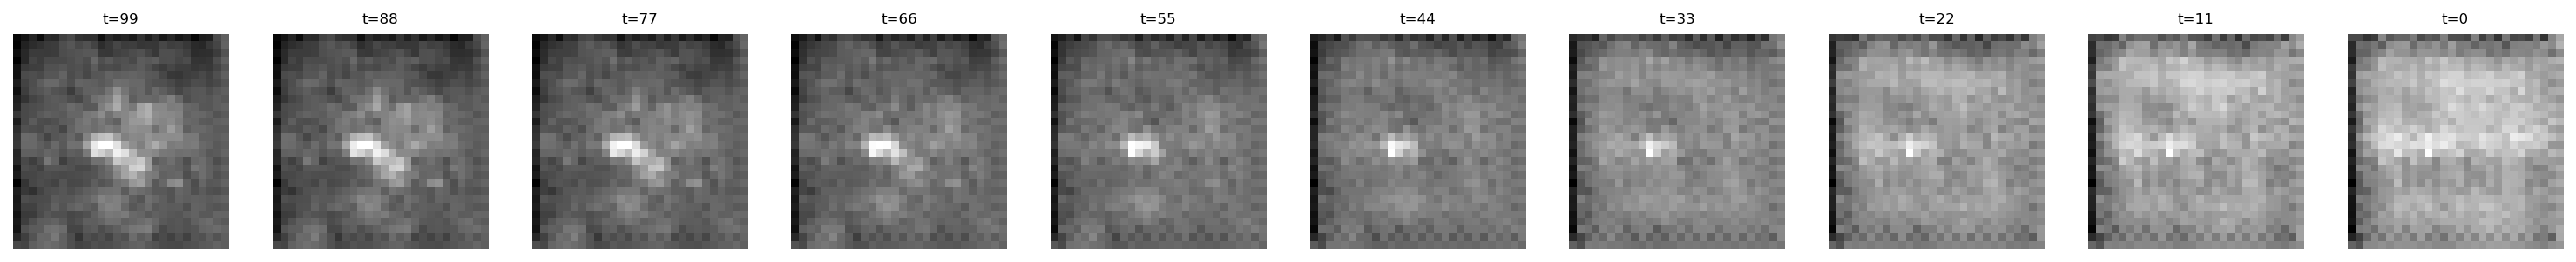


 Epoch: 24/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41649535


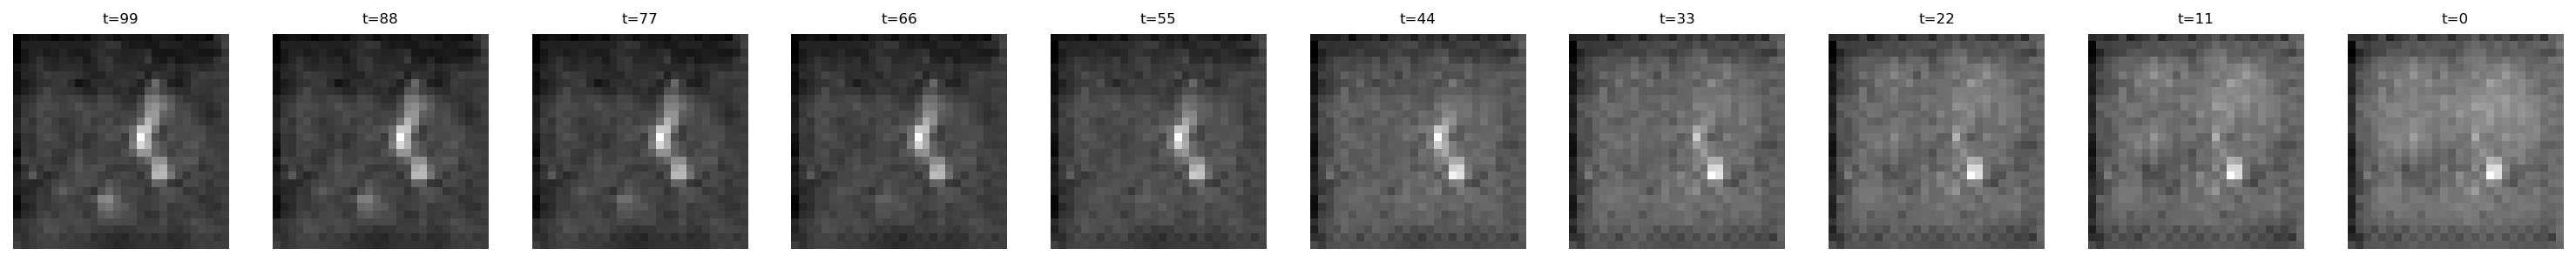


 Epoch: 25/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.4159834


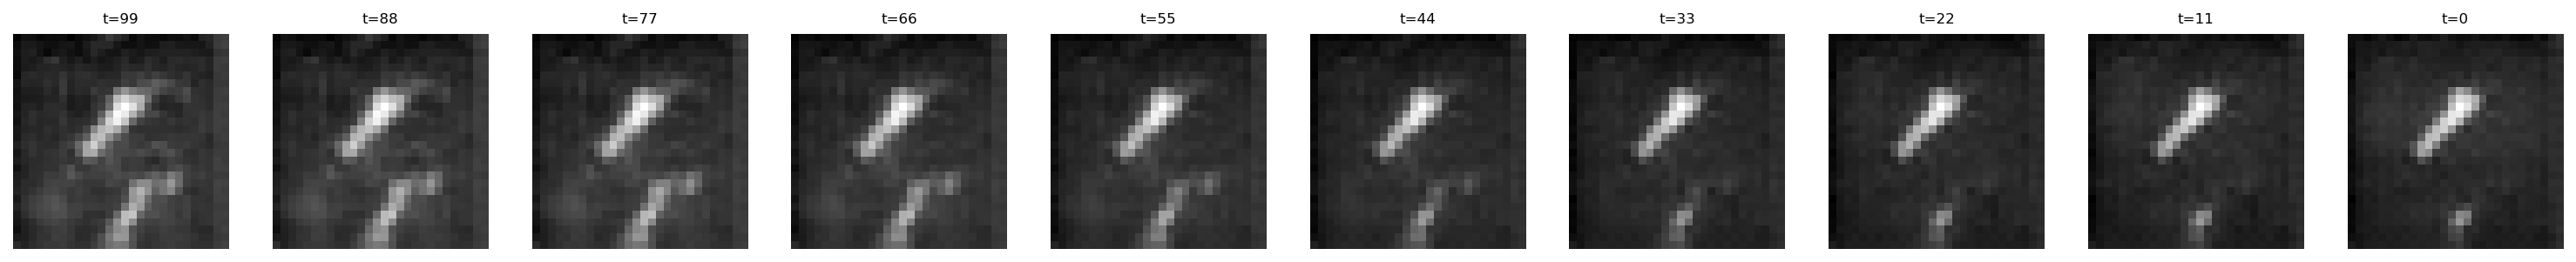


 Epoch: 26/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.4161588


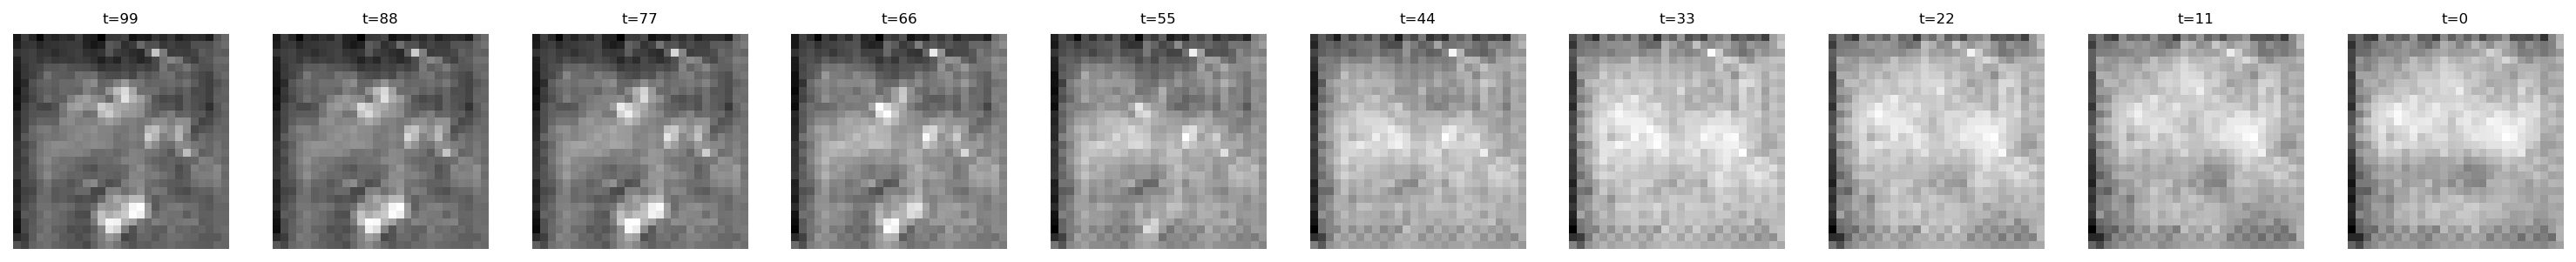


 Epoch: 27/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.4154389


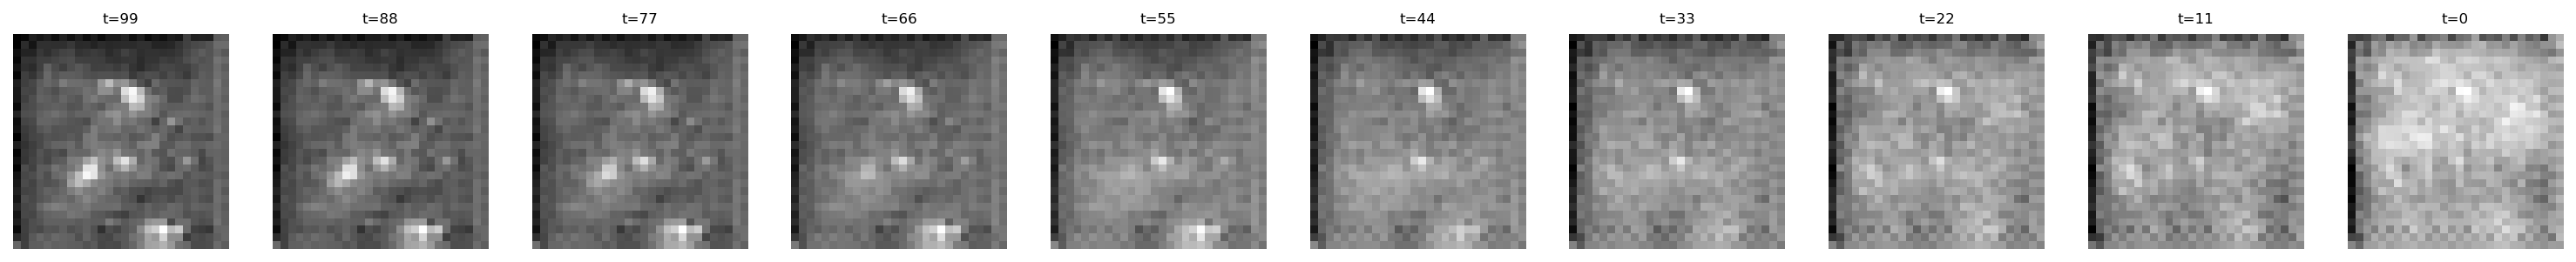


 Epoch: 28/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41572076


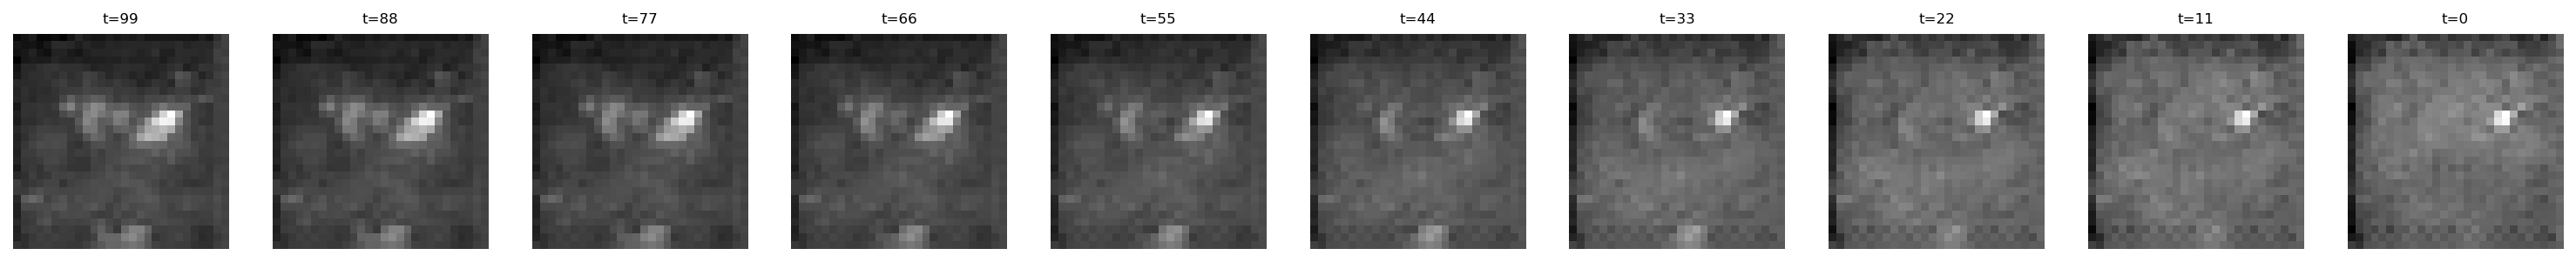


 Epoch: 29/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41439563


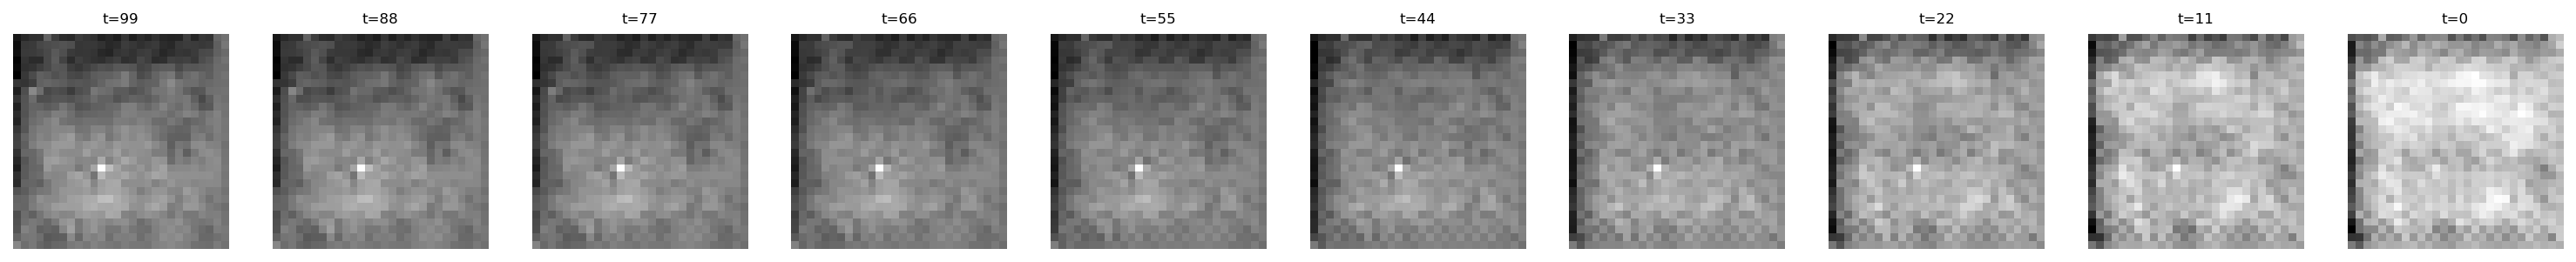


 Epoch: 30/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41487542


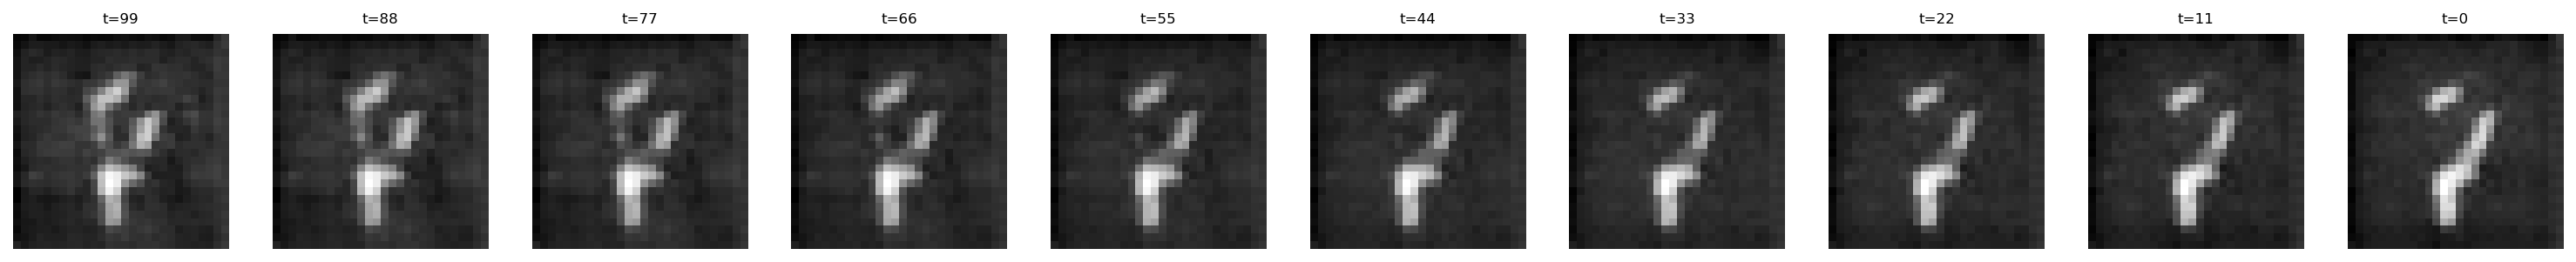


 Epoch: 31/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41368744


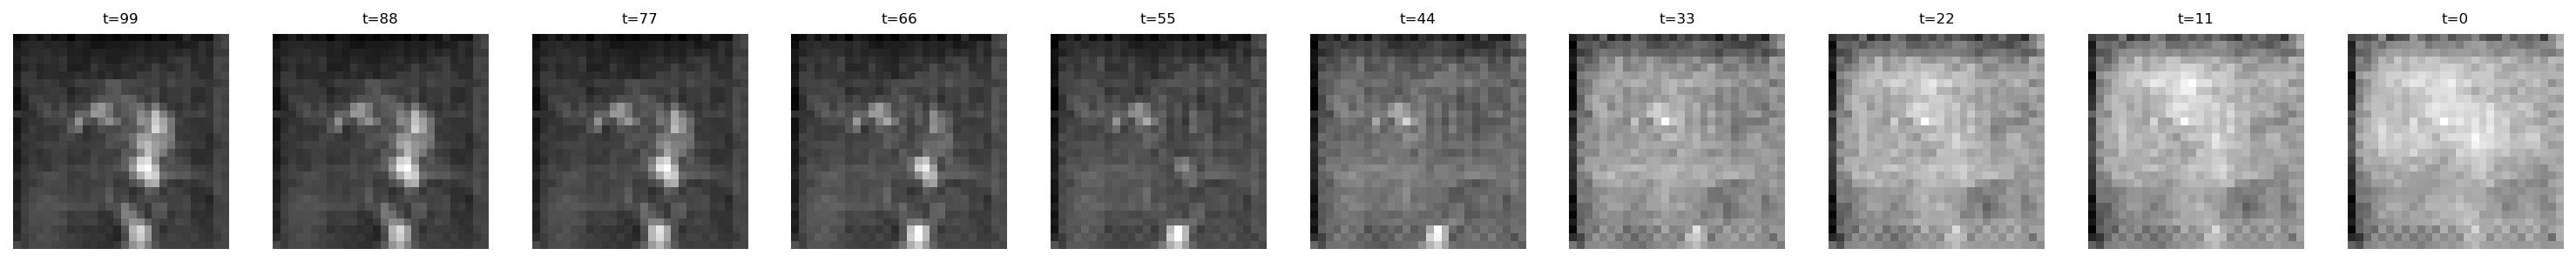


 Epoch: 32/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41426042


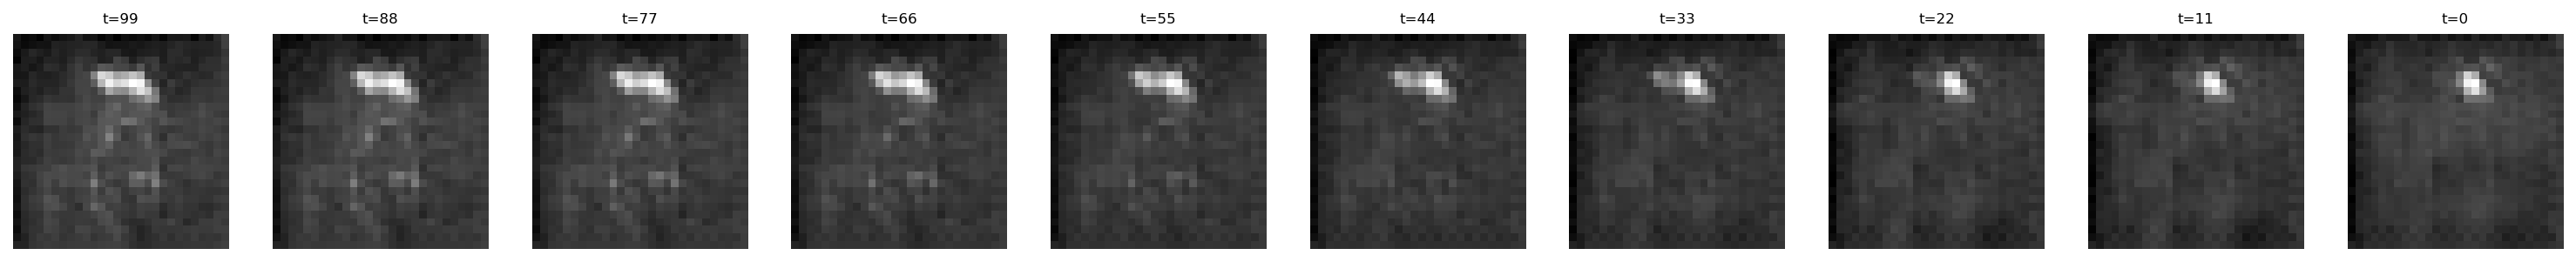


 Epoch: 33/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41487864


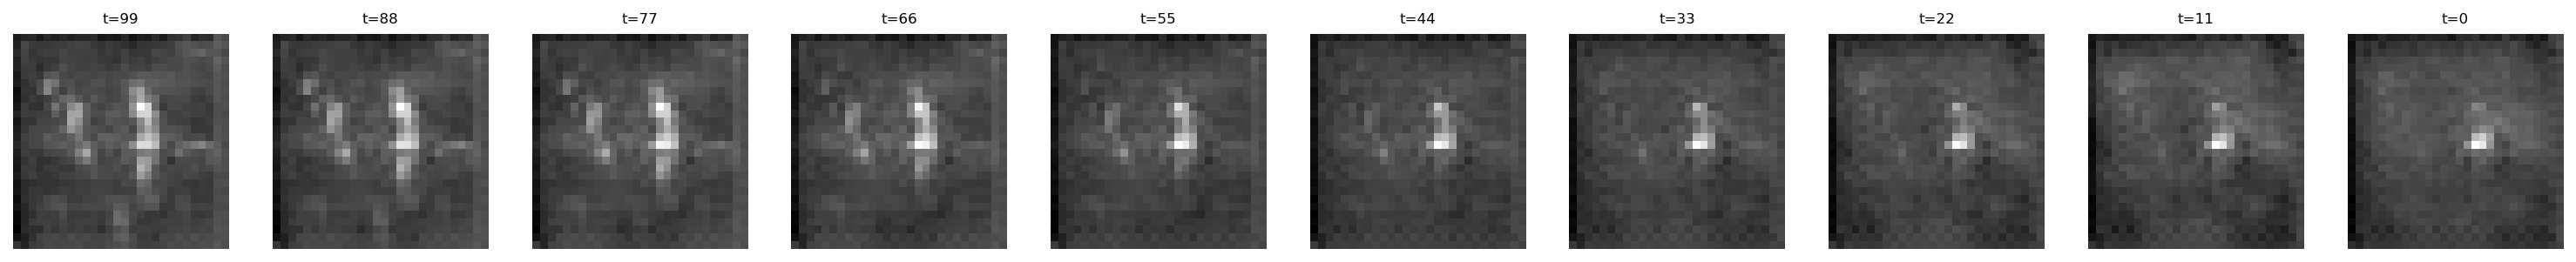


 Epoch: 34/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41461784


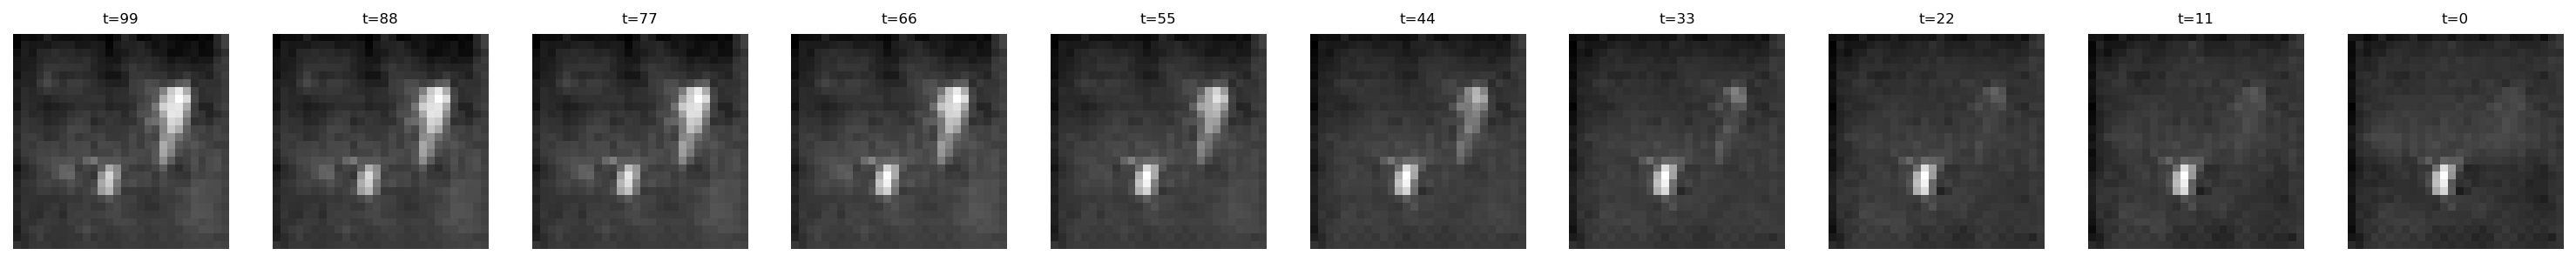


 Epoch: 35/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.412695


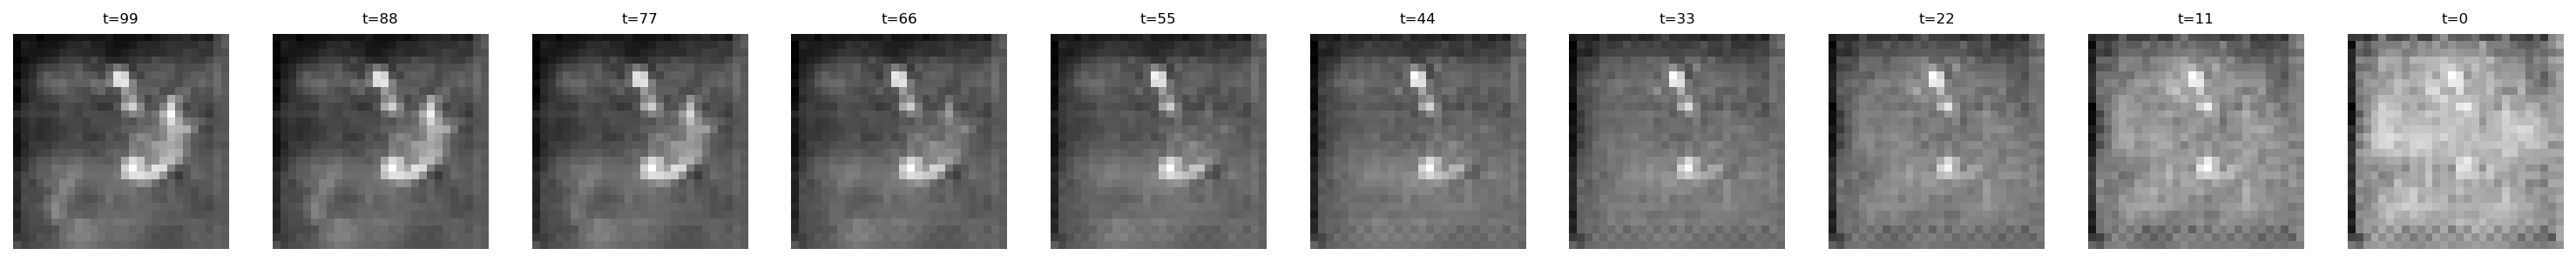


 Epoch: 36/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.4147559


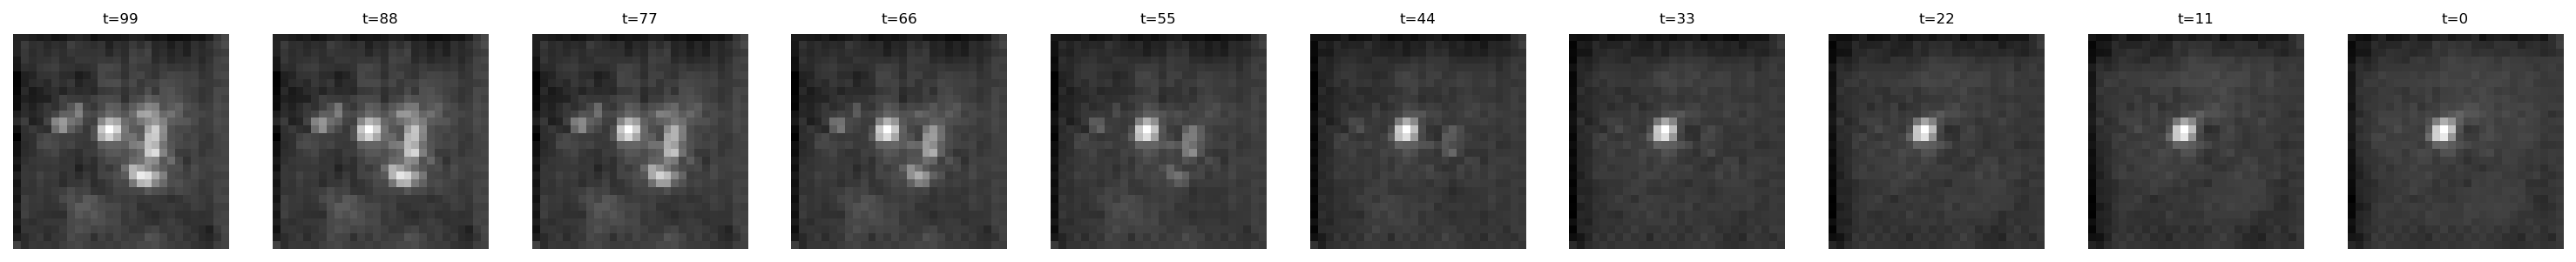


 Epoch: 37/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41374668


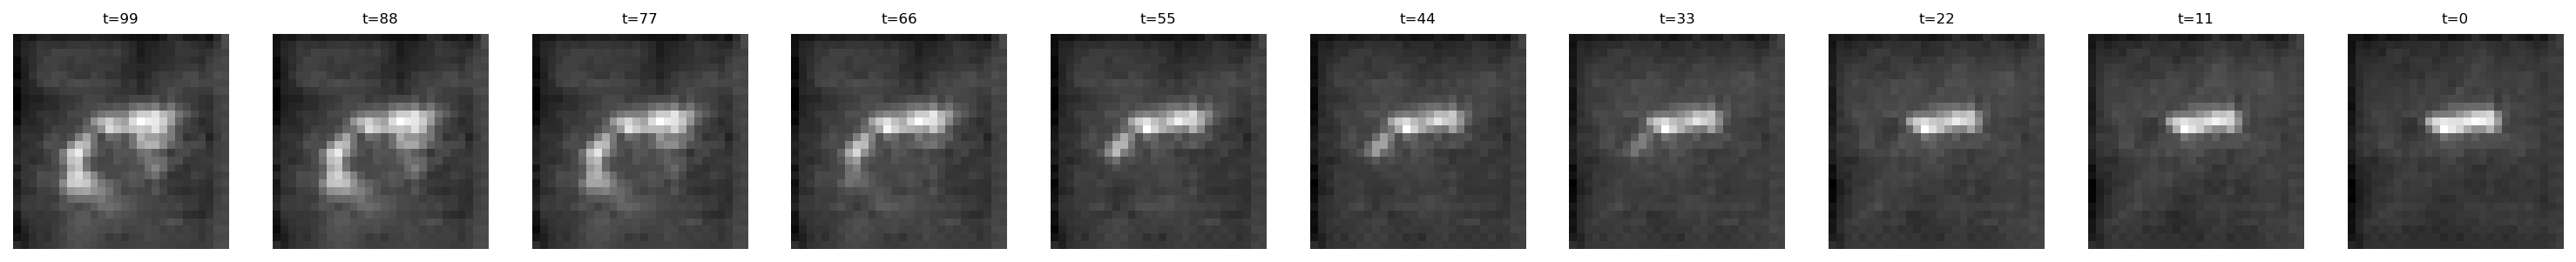


 Epoch: 38/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.4118114


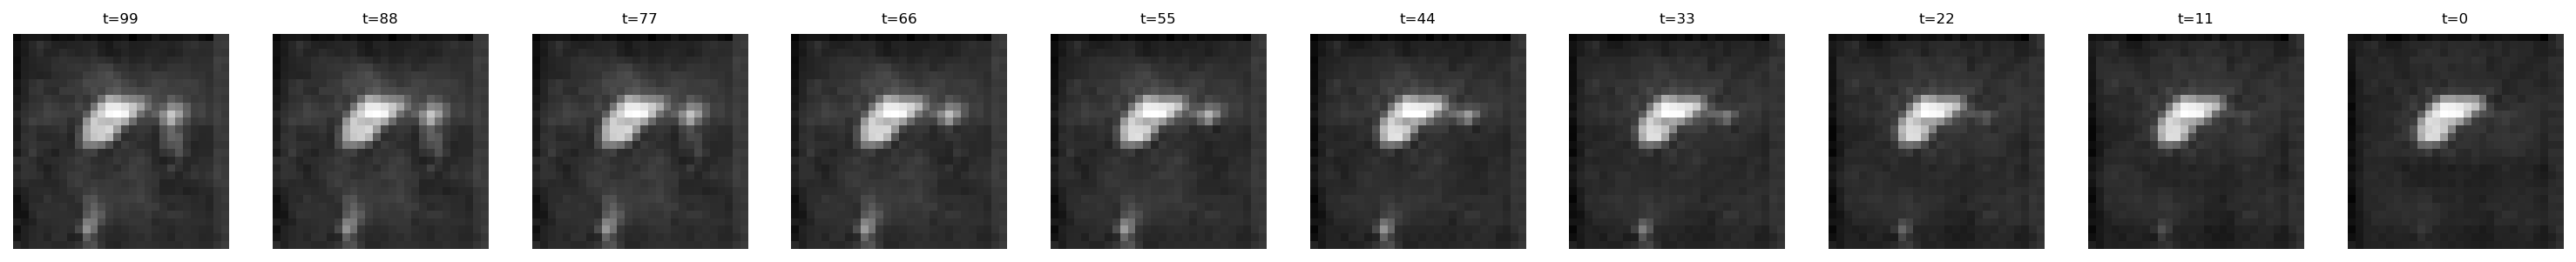


 Epoch: 39/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41302457


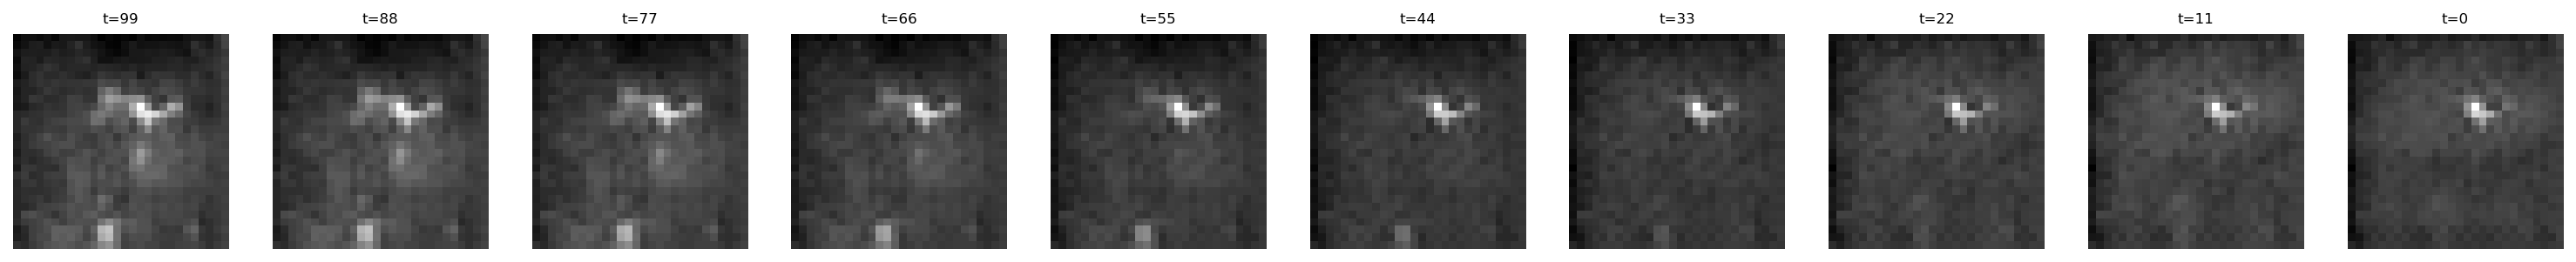


 Epoch: 40/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.4119217


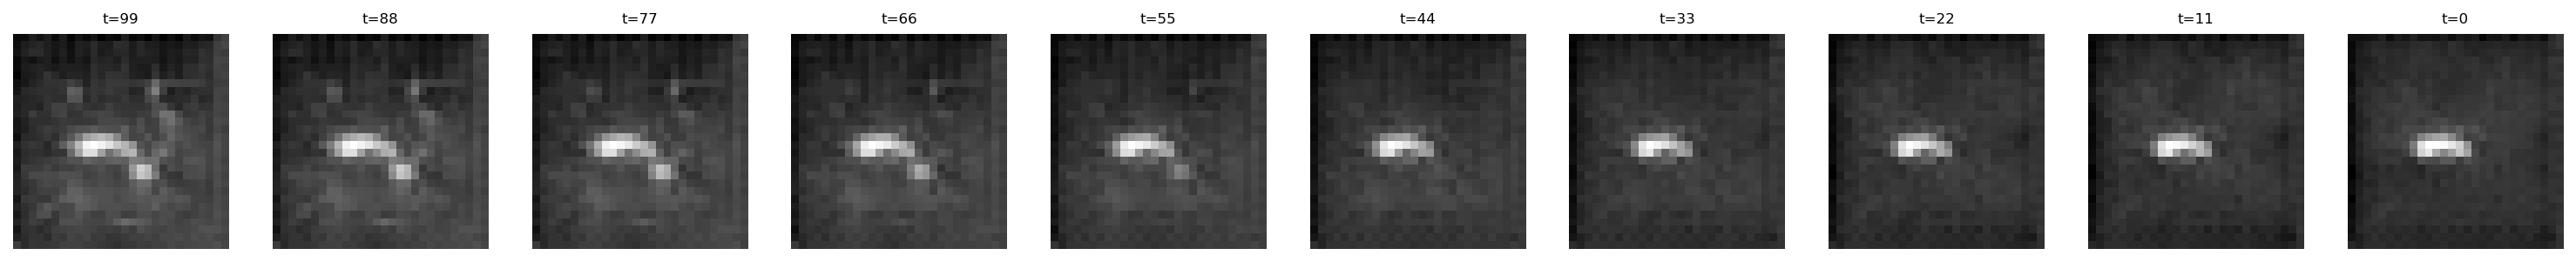


 Epoch: 41/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41320562


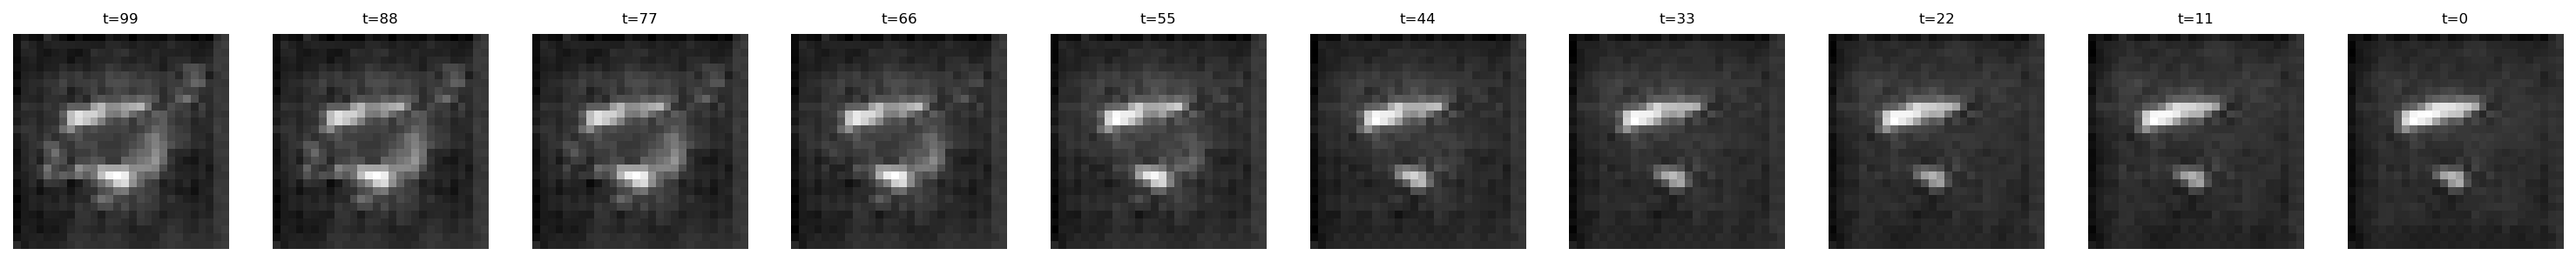


 Epoch: 42/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41351846


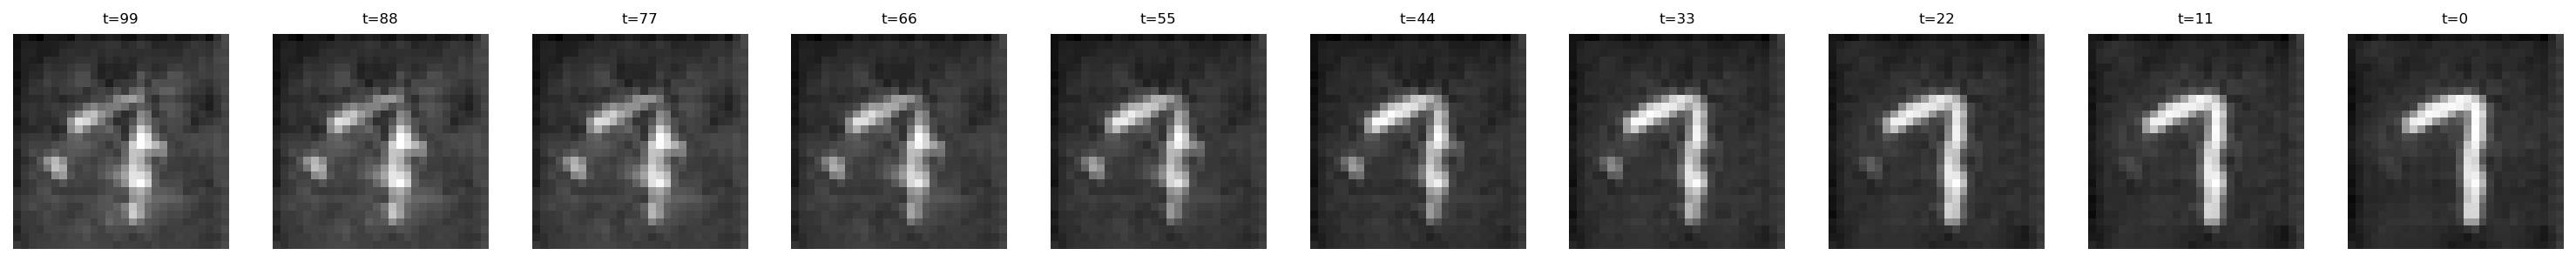


 Epoch: 43/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.4120576


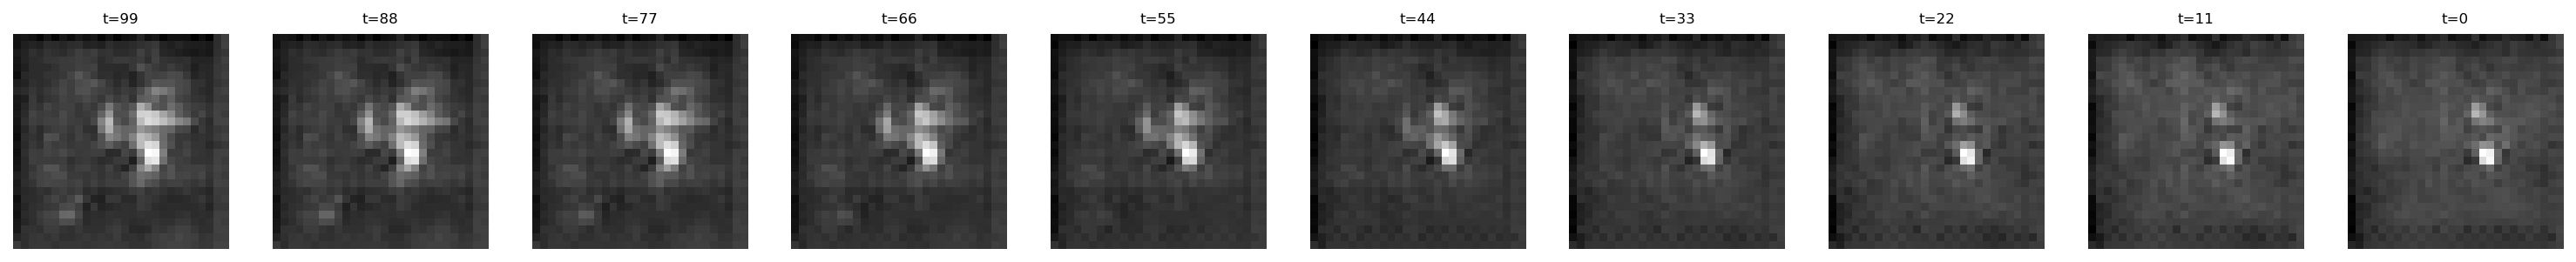


 Epoch: 44/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41250753


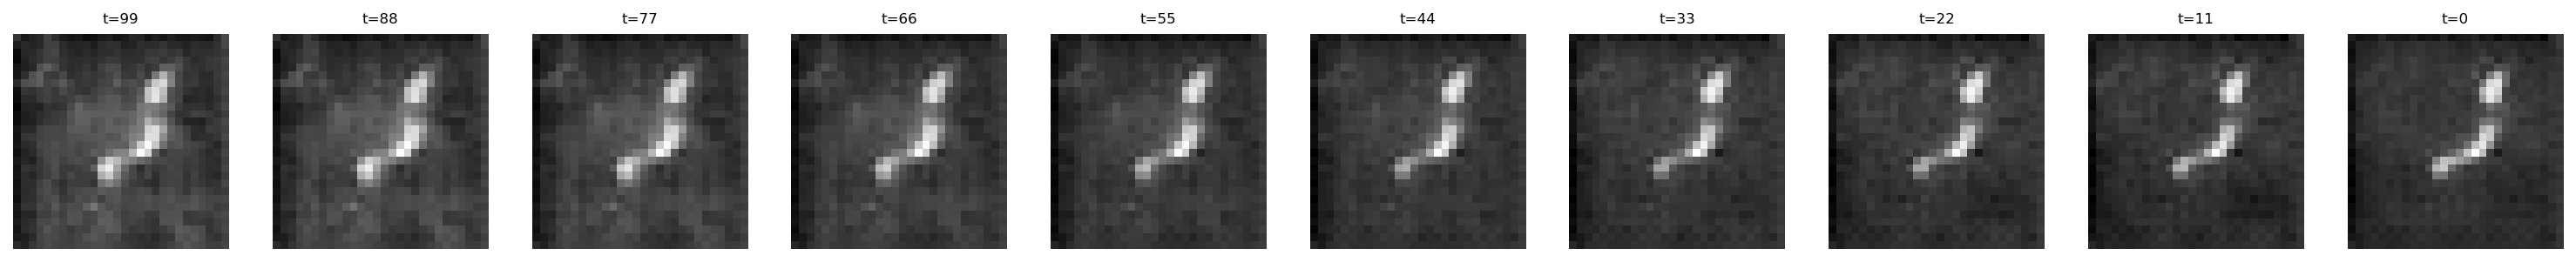


 Epoch: 45/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41189277


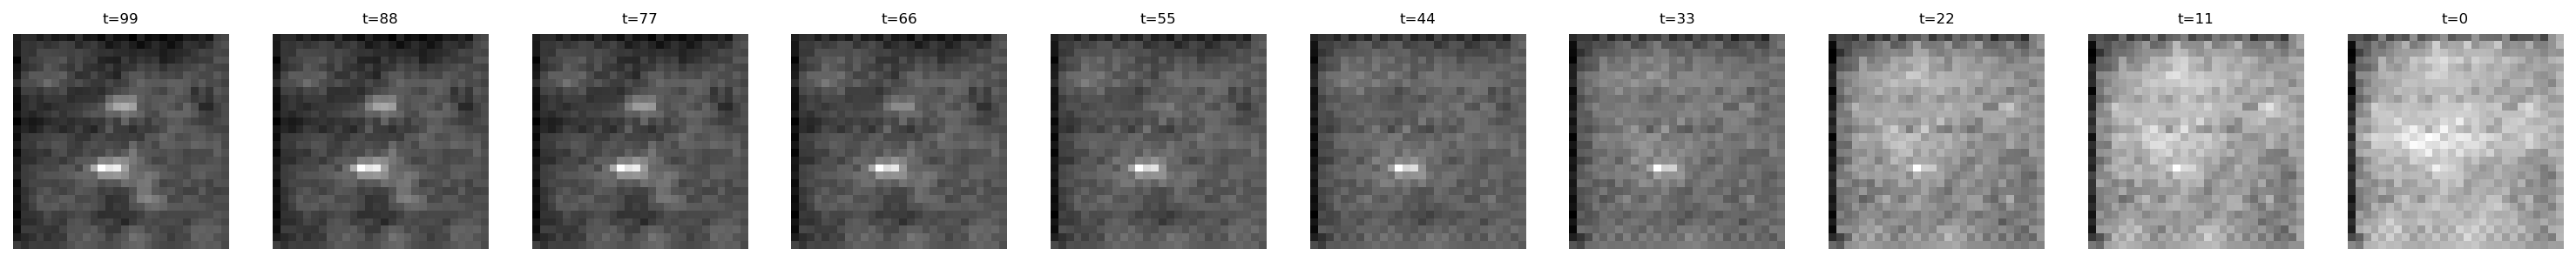


 Epoch: 46/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41166845


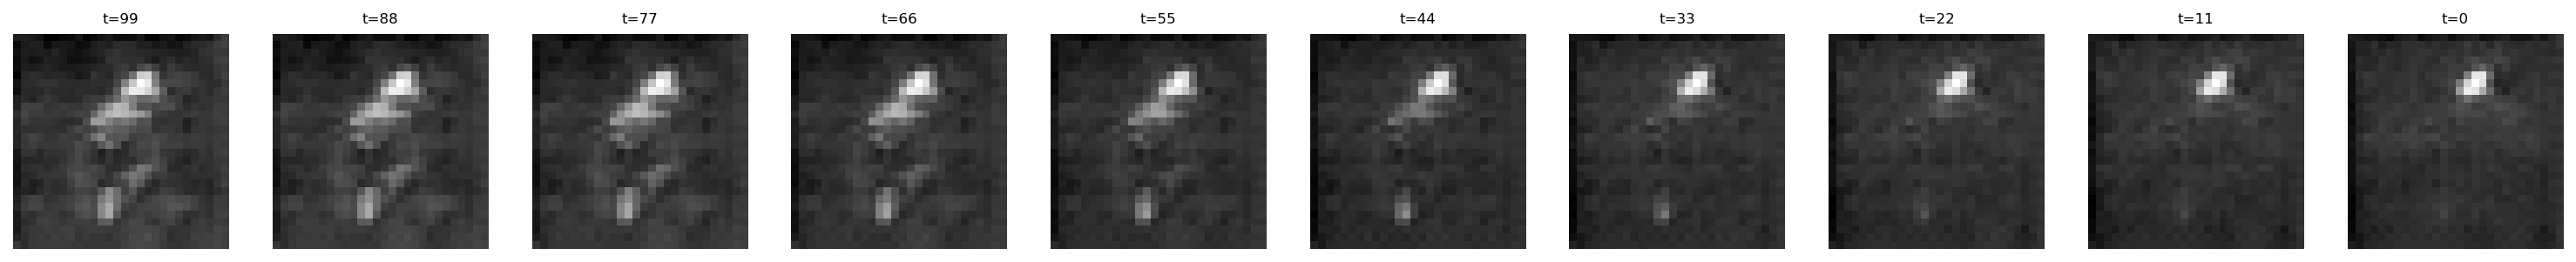


 Epoch: 47/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41222888


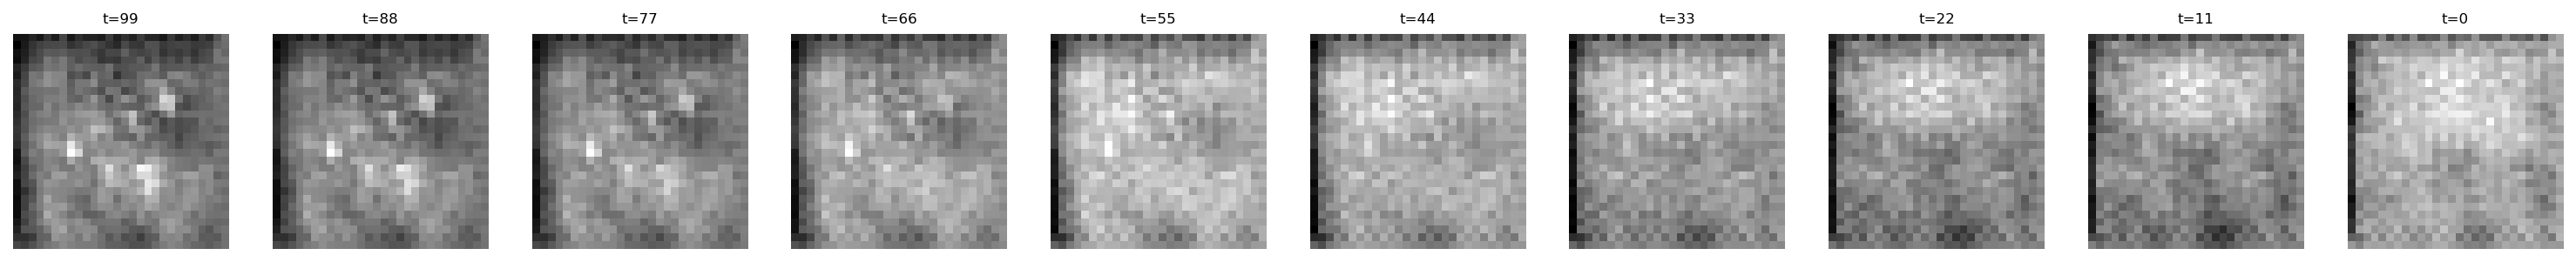


 Epoch: 48/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.41173586


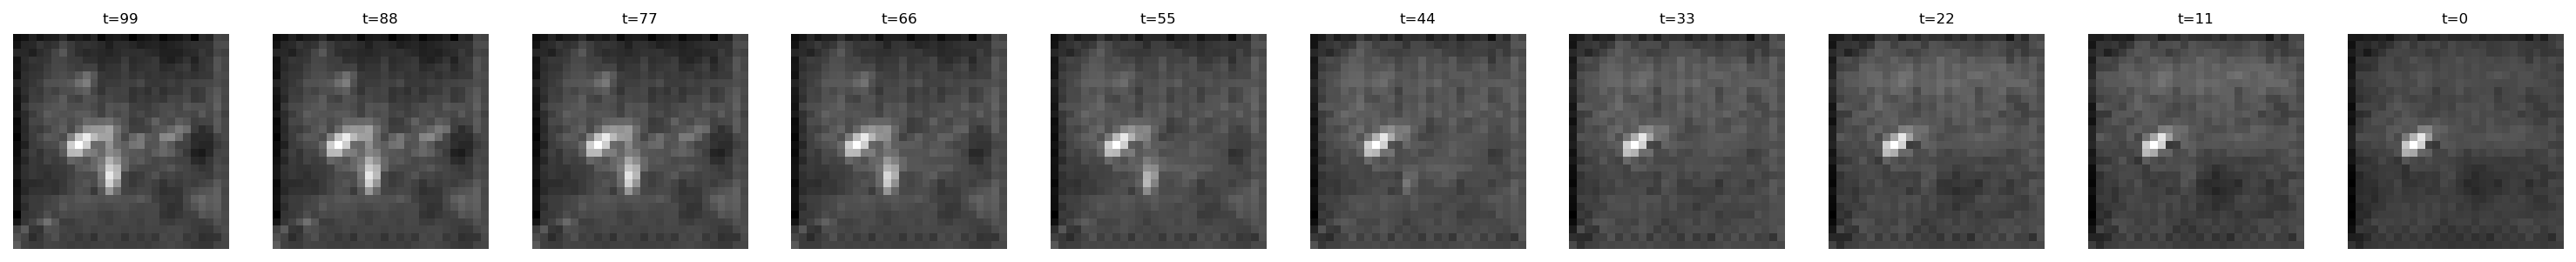


 Epoch: 49/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.411632


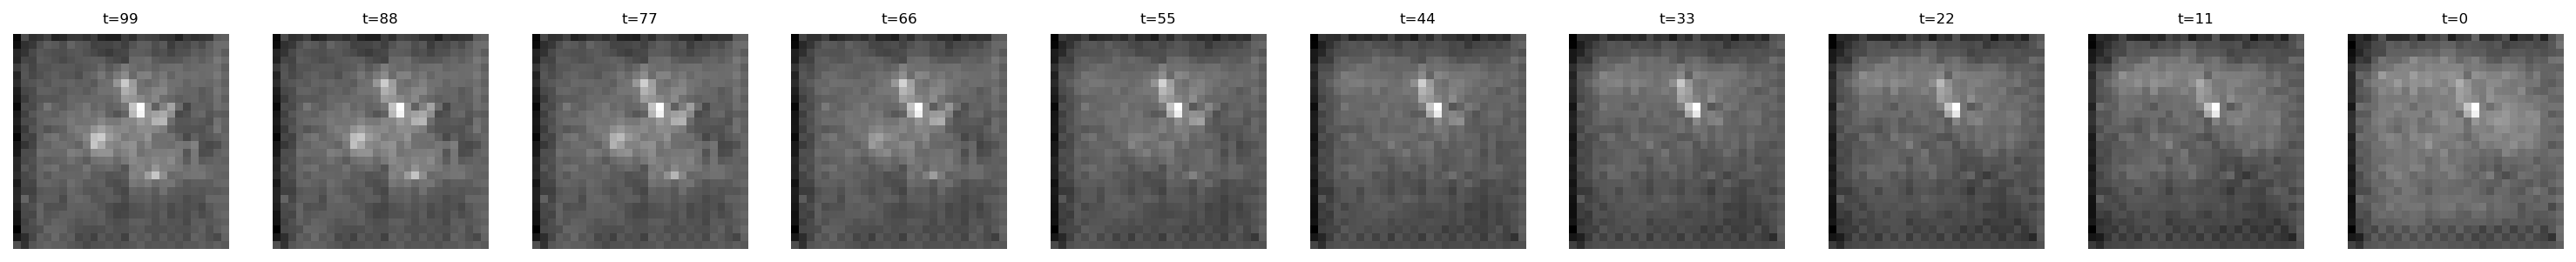


 Epoch: 50/50


train:   0%|          | 0/469 [00:00<?, ?it/s]

Loss = 0.411098


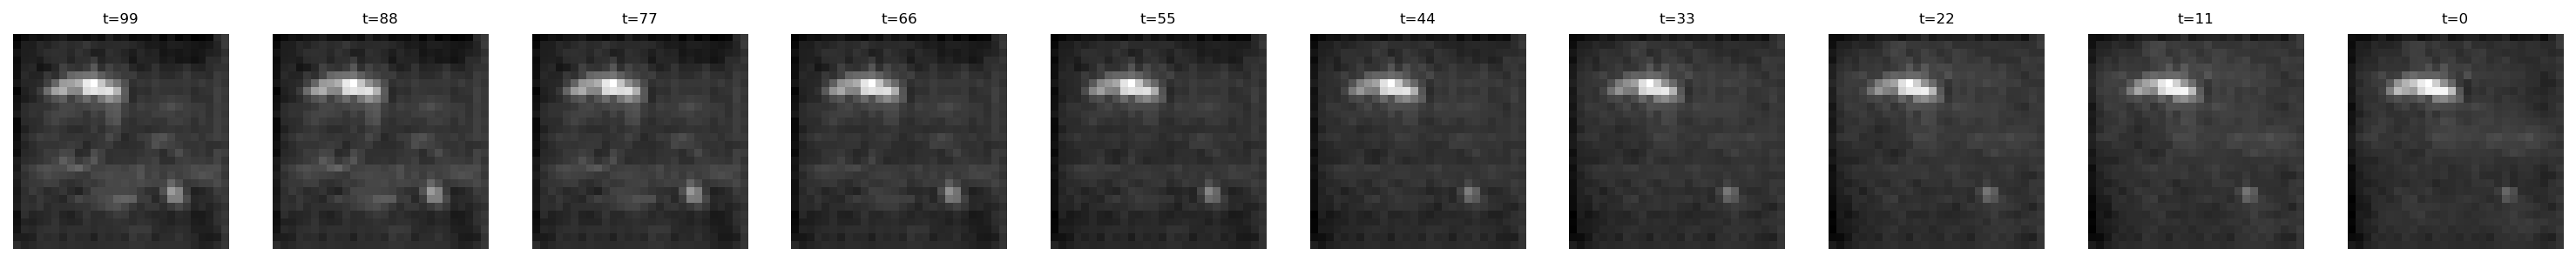

In [11]:
all_epochs = 50

# 2. Фиктивный проход, чтобы ленивые слои создали параметры
with torch.no_grad():
    # z — тензор латента: BxCxHxW, например B=1, C=4, H=W=7 (как у вас в train_loop)
    z = torch.zeros(1, 32, 7, 7, device=device)
    # cond — конкатенированный one-hot (10) + timestep (1) = 11
    cond = torch.zeros(1, 11, device=device)
    _ = unet(z, mix=True, c=cond, n=1)   # mix=True, чтобы пройти через mixing_layer

trainer = Diffusion_Trainer(
    model=unet,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    vae=vae,
    epochs=all_epochs
)

for epoch in range(all_epochs):
    print(f"\n Epoch: {epoch + 1}/{all_epochs}")
    trainer.train_loop()
    trainer.val_loop(iteration=epoch)

torch.save(unet.state_dict(), "Unet_diffusion_v6.pt")


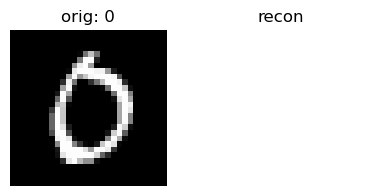

In [381]:
import random
def test_random_reconstruction(model, vae, noise_sched, val_loader, device='cuda'):
    model.eval()
    vae.eval()

    # 1) Выбираем случайный пример из val_loader
    all_data = []
    for x, y in val_loader:
        all_data.append((x, y))
    # Разворачиваем батчи в плоский список
    flat = []
    for xb, yb in all_data:
        for i in range(xb.size(0)):
            flat.append((xb[i : i + 1], yb[i : i + 1]))
    # Случайный индекс
    x0, y0 = random.choice(flat)
    x0 = x0.to(device)  # [1,1,28,28]

    # 2) Кодируем в латент
    with torch.no_grad():
        z0, _, _ = vae.sample(x0)      # [1, C_lat, H_lat, W_lat]

    # 3) Зашумляем до T-го шага (полный шум)
    T = noise_sched.steps
    aT = noise_sched.alpha_hat[T - 1].to(device)
    noise = torch.randn_like(z0)
    v = torch.sqrt(aT) * z0 + torch.sqrt(1 - aT) * noise

    # 4) Полностью восстанавливаем 0-й шаг
    with torch.no_grad():
        for t in reversed(range(T)):
            t_tensor = torch.tensor([[float(t)]], device=device)
            # достаём метку (нужна только для mask-conditioning, можно заменить на 0)
            y_onehot = torch.nn.functional.one_hot(y0.to(device), 10).float()
            cond = torch.cat([y_onehot, t_tensor], dim=1)
            # предсказание шума
            eps_pred = model(v, mix=True, c=cond, n=1)
            # шаг назад
            v = noise_sched.restore_image(v, eps_pred, t, sigma=0.0)

    # 5) Декодим итоговый латент в картинку
    with torch.no_grad():
        x_rec = vae.decode(v.to(torch.float32))  # [1,1,28,28]

    # 6) Визуализируем
    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
    axes[0].imshow(x0.squeeze().cpu(), cmap='gray')
    axes[0].set_title(f"orig: {int(y0.item())}")
    axes[0].axis('off')

    axes[1].imshow(x_rec.squeeze().cpu(), cmap='gray')
    axes[1].set_title("recon")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


# Пример использования:
test_random_reconstruction(
    model=unet,
    vae=vae,
    noise_sched=trainer.noise_sched,
    val_loader=val_dataloader,
    device=device
)

In [303]:
z = vae.sample(torch.randn([1, 1, 28, 28]))[0]
o = unet(z)
ov = vae.decode(o)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [12]:
z.shape, o.shape, ov.shape

(torch.Size([1, 4, 7, 7]),
 torch.Size([1, 4, 7, 7]),
 torch.Size([1, 1, 28, 28]))

In [13]:
sum([x.numel() for x in unet.parameters()])

212836

In [18]:


_ = unet(torch.randn([1, 4, 28, 28]))
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST('./data', train=True,  download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=config['train']['batch_size'], shuffle=config['train']['shuffle'], num_workers=0, pin_memory=config['train']['pin_memory'])
val_dataloader = DataLoader(val_dataset, batch_size=config['val']['batch_size'], shuffle=config['val']['shuffle'], num_workers=0, pin_memory=config['val']['pin_memory'])



In [15]:
trainer = Diffusion_Trainer(unet, train_dataloader, val_dataloader, vae, 50)

In [16]:
vae_losses_rec = []
vae_losses_kld = []

In [17]:
vae_optimizer = torch.optim.SGD(vae.parameters(), lr=1e-4, momentum=1e-2)
vae.train()

for ep in range(5):
    pbar = tqdm(train_dataloader, desc = 'train')
    for image, _ in pbar:
        with torch.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
            k = torch.rand(1).item()
            if ep == 1:
                k = k/2
            if ep == 2:
                k = k/20
            if ep == 4:
                k = 1e-5
            image = (1-k) * image + k * torch.rand_like(image)

            z, mu, logvar = vae.sample(image)

            output = vae.decode(z)

            recon = nn.functional.mse_loss(output, image, reduction='none')
            KLD = vae.KLD_loss(mu, logvar)

            vae_losses_rec.extend(recon.detach().mean(dim=[1, 2, 3]).cpu().numpy().tolist())
            vae_losses_kld.append(KLD.detach().cpu().item())

        loss = recon.mean() + 0.1*(0.5+k) * KLD
        vae_optimizer.zero_grad()
        loss.backward()
        vae_optimizer.step()
        pbar.desc = f'{ep} epoch, train, loss = {torch.mean(loss.detach().cpu()):.3f}'

train:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

In [18]:
torch.save(vae.state_dict(), "vae_noisy3.pt")

In [19]:
len(vae_losses_rec)

300000

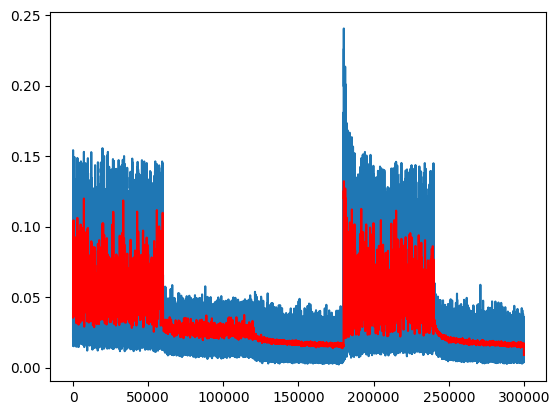

In [20]:
import seaborn as sns
N_W = 129
rl = nn.functional.conv1d(torch.tensor(vae_losses_rec).view(1, -1), torch.ones([1, 1, N_W])/N_W, None, padding=N_W//2)
sns.lineplot(vae_losses_rec)
sns.lineplot(rl.flatten(), c='r')
plt.show()


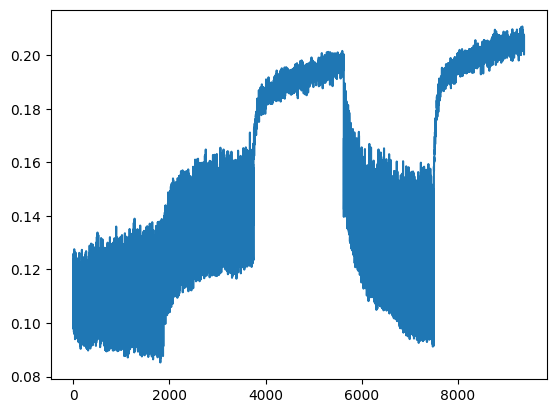

In [21]:
sns.lineplot(vae_losses_kld)
plt.show()

In [22]:
trainer.draw_diffusion(8, -1)

In [ ]:
# train_dataloader, val_dataloader -- объявить/загрузить етц

for epoch in tqdm(range(0, 100)):
    trainer.train_loop(0.3/(epoch+0.1), epoch)
    #trainer.val_loop(epoch)
    trainer.draw_diffusion(20, epoch)
torch.save(unet.state_dict(), "lunet2.pt")


  0%|          | 0/100 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.9403383


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.9070233


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8968202


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8878893


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.886407


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.7538409


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.7400508


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.7017579


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.6068003


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.5936346


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.5858516


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.5836596


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.5807475


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.5797797


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.5771639


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8976713


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8764037


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8697206


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8641058


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8632473


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8602625


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8593501


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8569946


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8544558


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8555914


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8490565


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.848746


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.846022


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8446443


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8438727


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8433061


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8424395


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8408574


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8389578


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8372197


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8406179


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8396612


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8381783


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8386236


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8379655


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8368108


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8322827


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8336868


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.832802


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8316756


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8324388


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8307756


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8315396


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8298099


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8326912


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8289709


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8297229


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8309093


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8294082


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8298306


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8293666


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8298908


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8296214


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8304304


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8284322


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8278122


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8272499


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8303528


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8293432


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8272597


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8274865


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8287247


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8268573


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8271416


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8282689


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8275677


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8265078


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8270457


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8266169


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8271532


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8252659


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.825108


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8273417


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8272524


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8249198


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8257377


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8256545


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8265305


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8248239


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8248578


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8247524


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8244476


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8247414


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8257798


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8241675


train:   0%|          | 0/1875 [00:00<?, ?it/s]

Loss = 1.8268352


train:   0%|          | 0/1875 [00:00<?, ?it/s]

In [ ]:
torch.save(vae.state_dict(), "lvae2.pt")


In [ ]:
# train_dataloader, val_dataloader -- объявить/загрузить етц

for epoch in tqdm(range(0, 25)):
    trainer.train_loop(0.3/(epoch+0.1), epoch)
    #trainer.val_loop(epoch)
    trainer.draw_diffusion(20, epoch)
torch.save(unet.state_dict(), "lunet2_1.pt")


  0%|          | 0/25 [00:00<?, ?it/s]

train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.5616821


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.5545578


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.1324679


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.1276345


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.1247716


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.1231635


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.5592561


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.5525165


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.5526032


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.5508137


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.5952965


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.5910475


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.5918002


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.5920174


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.5910122


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.5896956


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.6182711


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.6182817


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.6185801


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.6199836


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.6170841


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.6153047


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.6190747


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.6188719


train:   0%|          | 0/938 [00:00<?, ?it/s]

Loss = 1.6148546


In [ ]:
torch.save(unet.state_dict(), "lunet2.pt")


In [ ]:


_ = unet(torch.randn([1, 1, 28, 28]))
transform = transforms.Compose([transforms.ToTensor()])
train_ds = torchvision.datasets.MNIST('./data', train=True,  download=True, transform=transform)
val_dataset   = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)
train_dataloader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=0, pin_memory=config['train']['pin_memory'])
val_dataloader   = DataLoader(val_dataset,   batch_size=1, shuffle=False, num_workers=0, pin_memory=config['val']['pin_memory'])



In [ ]:
trainer = Diffusion_Trainer(unet, train_dataloader, val_dataloader, 400)

In [ ]:
# train_dataloader, val_dataloader -- объявить/загрузить етц

for epoch in tqdm(range(0, 400)):
    #trainer.train_loop(1/(((epoch-4)**2+1)), epoch)
    trainer.train_loop(0.005/(epoch+0.1), epoch)
    trainer.val_loop(epoch)
    trainer.draw_diffusion(8, epoch+1001)
torch.save(unet.state_dict(), "6unet2.pt")


In [ ]:
torch.save(unet.state_dict(), "6unet3.pt")

In [ ]:
plt.imshow(unet(torch.randn([1, 1, 28, 28])/6+0.5, True, torch.tensor([100, 100], dtype=torch.float32))[0].detach().cpu().numpy()[0][0])
plt.show()

In [ ]:
def draw_diffusion(S=5):

    fig, axes = plt.subplots(11, S+1, figsize=(S+1, 11))
    #fig.set_figure(plt.figure(figsize=(10,S+1)))
    noise = torch.randn([1, 1, 28, 28])/6+0.5
    transformed_weight = [torch.clone(noise[0][0]).numpy() for _ in range(11)]
    print("Ось Y -- лейбл")
    for i in range(11):
        for j in range(S+1):
            if j>0:
                #noise[0][0].numpy()+
                transformed_weight[i] = (1-j/S)*transformed_weight[i] + (j/S)*unet(
                        torch.tensor(transformed_weight[i]).unsqueeze(0).unsqueeze(0),
                        i<10, torch.tensor([i, j*(100/S)], dtype=torch.float32)
                    )[0].detach().cpu().numpy()[0][0]
            axes[i, j].imshow(transformed_weight[i])
            axes[i, j].axis('off')
    plt.savefig('foo.png')
draw_diffusion(10)

In [ ]:
def plot_conv_layers(model):
    # Пройдем через все слои модели
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):  # Проверяем, является ли слой сверточным
            print(f"Layer: {name}")

            # Получим все веса в данном слое
            weights = module.weight.data
            print(weights.shape)

            if weights.shape[2]*weights.shape[3]==1:
                weights = weights.view(1, 1, weights.shape[0], weights.shape[1])
            if weights.shape[0]*weights.shape[1]*weights.shape[2]*weights.shape[3]==1:
                print(module.weight.data.item())
                continue

            # Определение размеров выводимых изображений
            grid_size = (weights.shape[1], weights.shape[0])  # Размер сетки (A, B)

            # Создадим трансформатор для нормализации изображений
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

            # Визуализируем каждый вес (свертку)
            fig, axes = plt.subplots(*grid_size)
            try:
                for i in range(grid_size[0]):
                    for j in range(grid_size[1]):
                        weight = weights[j, i, :, :]
                        transformed_weight = weight.squeeze()
                        if grid_size[0]>1:
                            # Отображаем изображение свертки в соответствующем ячейке сетки
                            if grid_size[1]>1:
                                axes[i, j].imshow(transformed_weight.numpy(), cmap='hot')
                                axes[i, j].axis('off')
                            else:
                                axes[i].imshow(transformed_weight.numpy(), cmap='hot')
                                axes[i].axis('off')
                        else:
                            if grid_size[1]>1:
                                axes[j].imshow(transformed_weight.numpy(), cmap='hot')
                                axes[j].axis('off')
                            else:
                                axes.imshow(transformed_weight.numpy(), cmap='hot')
                                axes.axis('off')
            except:
                pass

            plt.suptitle(f"Conv Layer {name}")
            plt.show()

In [ ]:
plot_conv_layers(unet)

In [ ]:
def draw_diffusion(S=5):

    fig, axes = plt.subplots(11, S+1, figsize=(S+1, 11))
    #fig.set_figure(plt.figure(figsize=(10,S+1)))
    noise = torch.randn([1, 1, 28, 28])/6+0.5
    transformed_weight = [torch.clone(noise[0][0]).numpy() for _ in range(11)]
    print("Ось Y -- лейбл")
    for i in range(11):
        for j in range(S+1):
            if j>0:
                #noise[0][0].numpy()+
                transformed_weight[i] =transformed_weight[i] + (1-j/S)* (unet(
                        torch.tensor(transformed_weight[i]).unsqueeze(0).unsqueeze(0),
                        i<10, torch.tensor([i, (j/S)*100], dtype=torch.float32)
                    )[0]).detach().cpu().numpy()[0][0]
            axes[i, j].imshow(transformed_weight[i])
            axes[i, j].axis('off')

draw_diffusion(10)